<a href="https://colab.research.google.com/github/Paoak/nlp-comparison-transformers-classical-methods/blob/main/nlp_comparison_transformers_classical_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практическая работа



**Автор:** Шелипов Алексей Александрович.

**Курс:** Разработчик нейросетей. "The Founder"

**Дата:** 2025  

**Тема:** Классификация текста с помощью трансформеров: сравнительный анализ с традиционными методами.

**Описание:** Данная работа посвящена исследованию эффективности трансформеров для задач классификации текста в сравнении с традиционными методами машинного обучения. В рамках проекта реализованы и сравнены различные подходы.

**Исследуемые методы:**
- Традиционные: SVM, Логистическая регрессия, Random Forest, Naive Bayes
- Современные: BERT-tiny, DistillBERT


**Датасет:** IMDb Movie Reviews (50,000 отзывов с бинарной классификацией тональности)

**Цели:**
1. Сравнить качество классификации различных подходов
2. Проанализировать интерпретируемость моделей
3. Оценить вычислительную эффективность методов

#1 Установка зависимостей и импорты

Перед началом работы, установим библиотеки и зависимости, что бы в дальнейшем не отвлекаться на это.

In [ ]:
!pip install transformers datasets torch scikit-learn seaborn plotly tqdm pandas numpy matplotlib wordcloud
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [ ]:
# Основные библиотеки для работы с данными
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
import re
import string
from collections import Counter
from wordcloud import WordCloud

# Библиотеки для обработки текста и ML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC, SVC
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import CalibratedClassifierCV

# Библиотеки для работы с трансформерами
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, pipeline, DataCollatorWithPadding
from datasets import Dataset, load_dataset
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as TorchDataset
import torch.nn.functional as F
# PEFT
from peft import LoraConfig, get_peft_model

# Утилиты
from tqdm.auto import tqdm
import random
import os
import time
from IPython.display import display, HTML

# Настройка визуализации
warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")

# Проверка доступности GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используемое устройство: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

# Установка seed для воспроизводимости
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("Все библиотеки успешно загружены!")

Используемое устройство: cuda
GPU: Tesla T4
Все библиотеки успешно загружены!


#2 Введение в проблематику

Представьте, что вы работаете в крупной компании и каждый день получаете тысячи отзывов о продукте. Как понять, какие из них положительные, а какие требуют немедленного внимания? Или представьте новостное агентство, которое должно автоматически сортировать статьи по категориям. Именно для решения таких задач существует **классификация текста** — одна из ключевых задач обработки естественного языка (NLP).

По сути, классификация текста — это процесс автоматического присвоения документу одной или нескольких категорий из заранее определённого набора. Эта задача может показаться простой для человека, но для машины она представляет серьёзный вызов: компьютер должен "понять" смысл текста и принять решение о его принадлежности к той или иной категории.

### **Основные применения классификации текста:**

- **Анализ тональности**: определение эмоциональной окраски отзывов, комментариев, постов в соцсетях
- **Категоризация контента**: автоматическая сортировка новостей, документов, электронных писем
- **Модерация контента**: выявление спама, токсичных комментариев, фейковых новостей
- **Медицинская диагностика**: классификация медицинских записей и симптомов

---
&nbsp;
### **Ключевая мысль исследования**: не существует универсально лучшего метода. Есть методы, которые лучше подходят для конкретных условий и требований. Наша задача — проанализировать  отличия и производительность, а затем научиться делать осознанный выбор между ними. Пора переходить от сухой теории к практике.


---

Далее, по ходу работы, мы будем сравнивать традиционные подходы ML и трансформеры и будем следовать следующим пайплайнам:

&nbsp;
**1 Традиционный пайплайн обработки текста**
```
Исходный текст
      ↓
Токенизация (разбиение на слова)
      ↓
Предобработка
      ↓
Векторизация (TF-IDF)
      ↓
Отбор признаков
      ↓
Классический ML-алгоритм (SVM/LogReg/NB)
      ↓
Предсказание класса
```

**2 Пайплайн обработки текста трансформером (классификация предложений BERT)**
![Пример](https://habrastorage.org/r/w1560/webt/mx/eo/u_/mxeou__qytr_9_2m6pxjo2icemc.png)


#3 Подготовка данных

In [ ]:
# Загрузка датасета IMDb
dataset = load_dataset("imdb")
print("Датасет IMDb успешно загружен!")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Датасет IMDb успешно загружен!


In [ ]:
# Количество примеров по сплитам и всего вместе
for split, ds in dataset.items():
    print(f"{split}: {len(ds)} примеров (num_rows={getattr(ds, 'num_rows', 'N/A')})")

total = sum(len(ds) for ds in dataset.values())
print(f"\nВсего примеров во всех сплитах: {total}")

# Вывод структуры / фич
print("\nСтруктура датасета (features):")
for split, ds in dataset.items():
    print(f"{split} columns: {ds.column_names}")
    print(f"{split} features: {ds.features}\n")

train: 25000 примеров (num_rows=25000)
test: 25000 примеров (num_rows=25000)
unsupervised: 50000 примеров (num_rows=50000)

Всего примеров во всех сплитах: 100000

Структура датасета (features):
train columns: ['text', 'label']
train features: {'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

test columns: ['text', 'label']
test features: {'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}

unsupervised columns: ['text', 'label']
unsupervised features: {'text': Value('string'), 'label': ClassLabel(names=['neg', 'pos'])}



In [ ]:
# Показываем примеры сразу после загрузки
print("\nПримеры из датасета (формат datasets):")
print(dataset['train'][:1])


Примеры из датасета (формат datasets):
{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the

In [ ]:
# Преобразование в pandas DataFrame для удобства работы
train_data = dataset['train'].to_pandas()
test_data = dataset['test'].to_pandas()

# Объединяем и перемешиваем для создания собственного разделения
full_data = pd.concat([train_data, test_data], ignore_index=True)
full_data = full_data.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Для ускорения обучения берем подвыборку
SAMPLE_SIZE = 25000
df = full_data.sample(n=SAMPLE_SIZE, random_state=SEED).reset_index(drop=True)

print(f"\nРазмер рабочего датасета: {len(df)} образцов")
print(f"Распределение классов:")
print(df['label'].value_counts())


Размер рабочего датасета: 25000 образцов
Распределение классов:
label
0    12525
1    12475
Name: count, dtype: int64


###3.1 Предобработка данных

В данном датасете label:0 - означает негативный озыв, а label:1 - положительный

In [ ]:
# Предобработка данных

# Базовая предобработка текста
def preprocess_text(text):
    """
    Согласно исследованию "A Comparative Study on TF-IDF feature Weighting Method",
    качественная предобработка критически важна для эффективности классификации.
    """
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Удаление URL-ссылок
    text = re.sub(r'<.*?>', '', text)  # Удаление HTML тегов
    text = re.sub(r'[^a-zA-Zа-яА-Я\s.,!?]', '', text)  # Удаление специальных символов, но сохранение базовой пунктуации
    text = ' '.join(text.split())  # Удаление лишних пробелов
    return text

# Продвинутая предобработка с учетом исследований по TF-IDF оптимизации
def advanced_preprocess_text(text):
    text = preprocess_text(text)  # Базовая очистка
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Обработка повторяющихся символов (например, "goooood" -> "good")
    words = [word for word in text.split() if len(word) > 1]  # Удаление слов длиной менее 2 символов
    return ' '.join(words)

# Применение предобработки
df['processed_text'] = df['text'].apply(preprocess_text)
df['advanced_processed'] = df['text'].apply(advanced_preprocess_text)

# Кодирование меток
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Анализ эффекта предобработки
print(f"Средняя длина исходного текста: {df['text'].str.len().mean():.2f}")
print(f"Средняя длина базовой предобработки: {df['processed_text'].str.len().mean():.2f}")
print(f"Средняя длина продвинутой предобработки: {df['advanced_processed'].str.len().mean():.2f}")

Средняя длина исходного текста: 1301.46
Средняя длина базовой предобработки: 1257.41
Средняя длина продвинутой предобработки: 1236.91


In [ ]:
print("\nПримеры обработанных данных:")
for i in range(3):
    print(f"Исходный: {df.iloc[i]['text']}")
    print(f"Базовый: {df.iloc[i]['processed_text']}")
    print(f"Продвинутый: {df.iloc[i]['advanced_processed']}")
    print("-" * 50)


Примеры обработанных данных:
Исходный: Every now and then some amateur will come out with a tired piece of action film making. this one is just so wrong I don't think i even need to comment about the plot, acting, script, camera work. because it have none!! If putting a muscle guy in cool leather jacket walking in slow-mo and throw in a funky rap song is the main ingredient of making a great action movie, then sayonara action movie!!
Базовый: every now and then some amateur will come out with a tired piece of action film making. this one is just so wrong i dont think i even need to comment about the plot, acting, script, camera work. because it have none!! if putting a muscle guy in cool leather jacket walking in slowmo and throw in a funky rap song is the main ingredient of making a great action movie, then sayonara action movie!!
Продвинутый: every now and then some amateur will come out with tired piece of action film making. this one is just so wrong dont think even need to commen

###3.2 Визуализация данных

In [ ]:
# Визуализация данных

label_map = {0: "neg", 1: "pos"}
df['label'] = df['label'].map(label_map)

# Создание интерактивных графиков
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Распределение классов', 'Длина текстов',
                   'Распределение длин по классам', 'Частые слова'],
    specs=[[{"type": "pie"}, {"type": "histogram"}],
           [{"type": "box"}, {"type": "bar"}]]
)

# График 1: Распределение классов
class_counts = df['label'].value_counts()
fig.add_trace(
    go.Pie(labels=class_counts.index, values=class_counts.values, name="Classes"),
    row=1, col=1
)

# График 2: Длина текстов
df['text_length'] = df['processed_text'].str.len()
fig.add_trace(
    go.Histogram(x=df['text_length'], name="Text Length"),
    row=1, col=2
)

# График 3: Распределение длин по классам
for label in df['label'].unique():
    data = df[df['label'] == label]['text_length']
    fig.add_trace(
        go.Box(y=data, name=f"Length {label}"),
        row=2, col=1
    )

# График 4: Частые слова
from collections import Counter
all_words = ' '.join(df['processed_text']).split()
word_freq = Counter(all_words).most_common(10)
words, frequencies = zip(*word_freq)

fig.add_trace(
    go.Bar(x=list(words), y=list(frequencies), name="Word Frequency"),
    row=2, col=2
)

fig.update_layout(height=800, title_text="Анализ данных")
fig.show()

###3.2 Разделение на train/val/test

In [ ]:
# Разделение на train/val/test

# Разделение данных
X = df['processed_text']
y = df['label_encoded']

# Сначала отделяем test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
# Затем разделяем оставшиеся данные на train (64%) и val (16%)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp)

print(f"Размеры выборок:")
print(f"Train: {len(X_train)} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(X_val)} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test: {len(X_test)} ({len(X_test)/len(df)*100:.1f}%)")

Размеры выборок:
Train: 16000 (64.0%)
Validation: 4000 (16.0%)
Test: 5000 (20.0%)


In [ ]:
# Проверка распределения классов
print(f"\nРаспределение классов в train:")
print(pd.Series(y_train).value_counts())


Распределение классов в train:
label_encoded
0    8016
1    7984
Name: count, dtype: int64


#4 Реализация традиционных моделей

In [ ]:
# Словарь для хранения моделей и результатов
traditional_models = {}
traditional_results = {}

##4.1 Для начала сравним и выберем лучший векторизатор.

**Векторизатор** — это алгоритм преобразования дискретного текстового входа в числовое представление (вектор признаков), пригодное для обработки методами машинного обучения.

**Вход:**
- Набор документов:  
  $D = \{d_1, d_2, \dots, d_n\}$, где каждый $d_i$ — текстовая последовательность.
- Гиперпараметры: размер словаря, диапазон n-грамм, минимальная и максимальная частота термов и т.п.

**Выход:**
- Матрица признаков:  
  $X \in \mathbb{R}^{n \times m}$, где:
  - $n$ — число документов.
  - $m$ — число признаков (размер словаря).
  - $X_i$ — вектор признаков документа $d_i$.
  - $X_{ij}$ — вес терма $t_j$ в документе $d_i$ (например, TF-IDF вес или просто частота).



In [ ]:
# Создание различных векторизаторов
vectorizers = {
    'TF-IDF (unigrams)': TfidfVectorizer(
        max_features=5000, ngram_range=(1, 1), stop_words='english', min_df=2
    ),
    'TF-IDF (1-2 grams)': TfidfVectorizer(
        max_features=10000, ngram_range=(1, 2), stop_words='english',
        min_df=2, max_df=0.95
    ),
    'Count (1-2 grams)': CountVectorizer(
        max_features=5000, ngram_range=(1, 2), stop_words='english', min_df=2
    )
}

In [ ]:
# Выбор лучшего векторизатора на основе валидации
print("Выбор оптимального векторизатора...")
best_vectorizer = None
best_score = 0

for name, vectorizer in vectorizers.items():
    # Обучение векторизатора
    X_train_vec = vectorizer.fit_transform(X_train)
    X_val_vec = vectorizer.transform(X_val)

    # Быстрое тестирование с логистической регрессией
    quick_model = LogisticRegression(random_state=SEED, max_iter=1000)
    quick_model.fit(X_train_vec, y_train)
    val_score = quick_model.score(X_val_vec, y_val)

    print(f"   {name}: {val_score:.4f}")

    if val_score > best_score:
        best_score = val_score
        best_vectorizer = vectorizer

print(f"Выбран лучший векторизатор с оценкой: {best_score:.4f}")

Выбор оптимального векторизатора...
   TF-IDF (unigrams): 0.8808
   TF-IDF (1-2 grams): 0.8830
   Count (1-2 grams): 0.8448
Выбран лучший векторизатор с оценкой: 0.8830


In [ ]:
# Финальная векторизация
X_train_vec = best_vectorizer.fit_transform(X_train)
X_val_vec = best_vectorizer.transform(X_val)
X_test_vec = best_vectorizer.transform(X_test)

print(f"Размерность векторного пространства: {X_train_vec.shape}")
print(f"Разреженность матрицы: {X_train_vec.nnz / np.prod(X_train_vec.shape):.4f}")

Размерность векторного пространства: (16000, 10000)
Разреженность матрицы: 0.0081


In [ ]:
print(f"{best_vectorizer}")

TfidfVectorizer(max_df=0.95, max_features=10000, min_df=2, ngram_range=(1, 2),
                stop_words='english')


##4.2 Описываем классические подходы

###4.2.1 Логистическая регрессия

В нашем случае мы подбираем оптимальное значение C с помощью валидации, а затем обучаем модель на лучших параметрах.

In [ ]:
# Логистическая регрессия

# Параметр C управляет силой регуляризации:
#   - маленькое C → сильная регуляризация (жёстче штрафуем за большие веса),
#   - большое C → слабая регуляризация (риск переобучения)
C_values = [0.1, 1.0, 10.0, 100.0]  # Список значений C, которые будем тестировать

# Переменные для хранения лучшего значения C и лучшей точности на валидации
best_c = 1.0
best_score = 0

# Перебираем все варианты C
for c in C_values:
    # Создаём временную модель логистической регрессии с данным C
    lr_temp = LogisticRegression(random_state=SEED, max_iter=1000, C=c)

    # Обучаем модель на обучающей выборке (векторизированные данные TF-IDF)
    lr_temp.fit(X_train_vec, y_train)

    # Получаем предсказания на валидационной выборке
    val_pred = lr_temp.predict(X_val_vec)

    # Вычисляем точность на валидации
    val_score = accuracy_score(y_val, val_pred)

    # Выводим результат для текущего C
    print(f"  C={c}: Validation Accuracy = {val_score:.4f}")

    # Если результат лучше текущего лучшего — обновляем best_c и best_score
    if val_score > best_score:
        best_score = val_score
        best_c = c

print(f"Выбран оптимальный параметр C = {best_c}")  # Выводим итоговое оптимальное значение C

  C=0.1: Validation Accuracy = 0.8588
  C=1.0: Validation Accuracy = 0.8830
  C=10.0: Validation Accuracy = 0.8785
  C=100.0: Validation Accuracy = 0.8618
Выбран оптимальный параметр C = 1.0


In [ ]:
# Финальное обучение модели на лучших параметрах
lr_model = LogisticRegression(
    random_state=SEED,
    max_iter=1000,
    C=best_c,
    solver='liblinear'  # solver='liblinear' — хорошо работает с разреженными матрицами (как у TF-IDF)
)

lr_model.fit(X_train_vec, y_train)  # Обучаем финальную модель на всей обучающей выборке
traditional_models['Logistic Regression'] = lr_model  # Сохраняем модель в словарь с классическими алгоритмами

### 4.2.2 SVM

Далее мы сравним Linear SVC (SVC - реализация SVM для класссификации, подходит для текстов) и RBF SVM (с предварительным снижением размерности с помощью TruncatedSVD для ускорения). Лучший вариант сохраним для финального использования.

In [ ]:
# SVM
# Для SVM тестируем разные kernels

# Линейный SVM
print("\n=== Линейный SVM ===")
start = time.time()

print("   Начинаем обучение LinearSVC...")
# Добавляем прогресс-бар для визуализации
with tqdm(total=100, desc="Обучение LinearSVC", ncols=200) as pbar:
    # Создаем LinearSVC
    svm_linear_base = LinearSVC(random_state=SEED, C=1.0, max_iter=1000, tol=1e-3)
    # Калибруем для получения вероятностей
    svm_linear = CalibratedClassifierCV(svm_linear_base, cv=3, method='sigmoid')
    # Обучение с обновлением прогресса
    svm_linear.fit(X_train_vec, y_train)
    pbar.update(100)
print("   Обучение завершено!")

val_pred_linear = svm_linear.predict(X_val_vec)
score_linear = accuracy_score(y_val, val_pred_linear)
time_linear = time.time() - start
print(f"Accuracy = {score_linear:.4f} | Время: {time_linear:.2f} сек")

# RBF SVM (ускоренный через TruncatedSVD)
print("\n=== RBF SVM (с TruncatedSVD) ===")
# Адаптивный выбор количества компонент
n_components = min(300, X_train_vec.shape[1])
svd = TruncatedSVD(n_components=n_components, random_state=SEED)
X_train_svd = svd.fit_transform(X_train_vec)
X_val_svd = svd.transform(X_val_vec)

start = time.time()
print("Начинаем обучение RBF SVM...")
svm_rbf = SVC(kernel='rbf', random_state=SEED, C=1.0, gamma='scale', probability=True,cache_size=1000, max_iter=1000, tol=1e-3)

# Добавляем прогресс-бар для визуализации
with tqdm(total=100, desc="Обучение RBF SVM", ncols=200) as pbar:
    # Обучение с обновлением прогресса
    svm_rbf.fit(X_train_svd, y_train)
    pbar.update(100)
print("   Обучение завершено!")
val_pred_rbf = svm_rbf.predict(X_val_svd)
score_rbf = accuracy_score(y_val, val_pred_rbf)
time_rbf = time.time() - start
print(f"Accuracy = {score_rbf:.4f} | Время: {time_rbf:.2f} сек")


=== Линейный SVM ===
   Начинаем обучение LinearSVC...


Обучение LinearSVC:   0%|                                                                                     …

   Обучение завершено!
Accuracy = 0.8798 | Время: 0.96 сек

=== RBF SVM (с TruncatedSVD) ===
Начинаем обучение RBF SVM...


Обучение RBF SVM:   0%|                                                                                       …

   Обучение завершено!
Accuracy = 0.7592 | Время: 62.46 сек


In [ ]:
# Выбираем лучший SVM
if score_linear >= score_rbf:
    svm_model = svm_linear
    print("\nВыбран Linear SVM")
else:
    svm_model = svm_rbf
    print("\nВыбран RBF SVM")

# Сохраняем модель
traditional_models['SVM'] = svm_model

# Сохраняем SVD трансформер, если он был создан
# Это нужно для корректной оценки RBF SVM в будущем
traditional_models['SVD_Transformer'] = svd
print(f"SVD трансформер сохранен для возможного использования RBF SVM")


Выбран Linear SVM
SVD трансформер сохранен для возможного использования RBF SVM


### 4.2.3 Random Forest

В данном случае подбираем оптимальное количество деревьев n_estimators по валидационной выборке.

In [ ]:
# Random Forest

n_estimators_values = [50, 100, 200]  # Возможное значения количества деревьев в ансамбле

# Переменные для хранения лучшего числа деревьев и точности
best_n = 100
best_rf_score = 0

# Перебираем разные значения количества деревьев
for n in n_estimators_values:
    # Создаём временную модель случайного леса
    # max_depth=None — дерево растёт до упора (пока не останется меньше min_samples_split объектов)
    # min_samples_split=5 — чтобы узел делился, в нём должно быть не менее 5 объектов
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        random_state=SEED,
        max_depth=None,
        min_samples_split=5
    )

    rf_temp.fit(X_train_vec, y_train)  # Обучаем модель на обучающей выборке
    val_pred = rf_temp.predict(X_val_vec)  # Предсказываем на валидационных данных
    val_score = accuracy_score(y_val, val_pred)  # Вычисляем точность
    print(f"  n_estimators={n}: Validation Accuracy = {val_score:.4f}")  # Выводим результат для текущего количества деревьев

    # Если модель показала лучшую точность — сохраняем параметры
    if val_score > best_rf_score:
        best_rf_score = val_score
        best_n = n

# Финальное обучение на лучших параметрах
rf_model = RandomForestClassifier(
    n_estimators=best_n,
    random_state=SEED,
    max_depth=None,
    min_samples_split=5,
    n_jobs=-1  # Параллельное выполнение на всех доступных ядрах процессора
)

rf_model.fit(X_train_vec, y_train)  # Обучаем модель на всей обучающей выборке
traditional_models['Random Forest'] = rf_model  # Сохраняем модель в словарь с классическими алгоритмами
print(f"Выбрано оптимальное количество деревьев: {best_n}")

  n_estimators=50: Validation Accuracy = 0.8413
  n_estimators=100: Validation Accuracy = 0.8492
  n_estimators=200: Validation Accuracy = 0.8502
Выбрано оптимальное количество деревьев: 200


###4.2.4 Naive Bayes
**Наивный Байесовский классификатор** — это простой, но эффективный алгоритм классификации, основанный на теореме Байеса с предположением, что все признаки независимы друг от друга (так называемое "наивное" предположение).

В задачах обработки текста часто используется Multinomial Naive Bayes, который хорошо работает с частотными признаками (TF-IDF), моделируя вероятность появления слов в документах разных классов.

В нашем случае мы используем MultinomialNB с alpha=1.0, что является стандартным значением сглаживания для текстовых данных.

In [ ]:
# Naive Bayes

# Создаём модель
# alpha=1.0 — параметр сглаживания Лапласа, помогает избежать нулевых вероятностей для слов, которых не было в обучающей выборке
nb_model = MultinomialNB(alpha=1.0)  # Лапласовское сглаживание
nb_model.fit(X_train_vec, y_train)  # Обучаем модель на обучающих данных (TF-IDF матрица)
traditional_models['Naive Bayes'] = nb_model  # Сохраняем модель в словарь с классическими алгоритмами

##4.3 Оценка моделей

Следущая функция *analyze_feature_importance* предназначена для интерпретации моделей машинного обучения, то есть для понимания того, какие признаки (слова в тексте) оказывают наибольшее влияние на предсказания модели.

- Для линейных моделей важность признаков напрямую связана с коэффициентами coef_.

- Для деревьев решений и случайного леса (Random Forest) используется feature_importances_.

- Для Naive Bayes берется разница log_probabilities между классами.

- Для kernel SVM (RBF) используется приближенный расчет через support vectors и dual coefficients.

**Цель:** понять, какие слова сильнее всего ассоциируются с положительным или отрицательным классом, что важно для:

- интерпретации моделей,
- отладки,
- улучшения модели через анализ данных.

In [ ]:
# Анализ важности признаков для интерпретируемости
def analyze_feature_importance(model, vectorizer, model_name, top_n=10):
    """
    Анализ важности признаков для интерпретации моделей
    """
    print(f"\nАнализ важности признаков для {model_name}:")

    try:
        if hasattr(model, 'coef_'):
            # Для линейных моделей
            if hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = vectorizer.get_feature_names_out()
            elif hasattr(vectorizer, 'get_feature_names'):
                feature_names = vectorizer.get_feature_names()
            else:
                print("Векторизатор не поддерживает извлечение имен признаков")
                return

            # Правильная обработка коэффициентов для бинарной классификации
            if len(model.coef_.shape) == 1:
                # Бинарная классификация - используем коэффициенты как есть
                coefficients = model.coef_[0]
            elif len(model.coef_.shape) == 2:
                if model.coef_.shape[0] == 1:
                    # Один класс - используем как есть
                    coefficients = model.coef_[0]
                else:
                    # Многоклассовая классификация - разность между классами
                    coefficients = model.coef_[1] - model.coef_[0]
            else:
                print("Неожиданная форма коэффициентов модели")
                return

            # Топ положительных признаков
            top_positive = np.argsort(coefficients)[-top_n:][::-1]
            print("Топ признаки для положительного класса:")
            for idx in top_positive:
                if idx < len(feature_names):
                    print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")

            # Топ отрицательных признаков
            top_negative = np.argsort(coefficients)[:top_n]
            print("Топ признаки для отрицательного класса:")
            for idx in top_negative:
                if idx < len(feature_names):
                    print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")

        elif hasattr(model, 'feature_importances_'):
            # Для tree-based моделей
            if hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = vectorizer.get_feature_names_out()
            elif hasattr(vectorizer, 'get_feature_names'):
                feature_names = vectorizer.get_feature_names()
            else:
                print("Векторизатор не поддерживает извлечение имен признаков")
                return

            importances = model.feature_importances_
            top_features = np.argsort(importances)[-top_n:][::-1]

            print("Топ важных признаков:")
            for idx in top_features:
                if idx < len(feature_names):
                    print(f"{feature_names[idx]}: {importances[idx]:.4f}")

        elif hasattr(model, 'coef_') and hasattr(model, 'support_'):
            # Для SVM с поддержкой feature importance
            if hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = vectorizer.get_feature_names_out()
            elif hasattr(vectorizer, 'get_feature_names'):
                feature_names = vectorizer.get_feature_names()
            else:
                print("Векторизатор не поддерживает извлечение имен признаков")
                return

            # Для SVM используем абсолютные значения коэффициентов
            coefficients = np.abs(model.coef_[0])
            top_features = np.argsort(coefficients)[-top_n:][::-1]

            print("Топ важных признаков (абсолютные значения коэффициентов):")
            for idx in top_features:
                if idx < len(feature_names):
                    print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")

        elif hasattr(model, 'support_vectors_') and hasattr(model, 'dual_coef_'):
            # Для RBF SVM и других kernel-based SVM
            if hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = vectorizer.get_feature_names_out()
            elif hasattr(vectorizer, 'get_feature_names'):
                feature_names = vectorizer.get_feature_names()
            else:
                print("Векторизатор не поддерживает извлечение имен признаков")
                return

            # Для kernel SVM используем приближенную важность через support vectors
            try:
                # Приближенная важность через анализ support vectors
                support_vectors = model.support_vectors_
                dual_coef = model.dual_coef_

                if len(support_vectors) > 0:
                    # Вычисляем приближенную важность через взвешенную сумму support vectors
                    feature_importance = np.zeros(support_vectors.shape[1])
                    for i, sv in enumerate(support_vectors):
                        weight = np.abs(dual_coef[0, i]) if dual_coef.shape[0] == 1 else np.abs(dual_coef[0, i])
                        feature_importance += weight * np.abs(sv)

                    # Нормализация
                    feature_importance = feature_importance / np.sum(feature_importance)

                    top_features = np.argsort(feature_importance)[-top_n:][::-1]

                    print("Топ важных признаков (приближенная важность через support vectors):")
                    for idx in top_features:
                        if idx < len(feature_names):
                            print(f"  {feature_names[idx]}: {feature_importance[idx]:.4f}")
                else:
                    print("   Нет support vectors для анализа")

            except Exception as e:
                print(f"Ошибка при анализе support vectors: {e}")
                print("Для RBF SVM анализ важности признаков ограничен")

        elif hasattr(model, 'feature_log_prob_'):
            # Для Naive Bayes - используем log probabilities
            if hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = vectorizer.get_feature_names_out()
            elif hasattr(vectorizer, 'get_feature_names'):
                feature_names = vectorizer.get_feature_names()
            else:
                print("Векторизатор не поддерживает извлечение имен признаков")
                return

            # Разность log probabilities между классами
            if len(model.feature_log_prob_) >= 2:
                log_probs_diff = model.feature_log_prob_[1] - model.feature_log_prob_[0]
                top_features = np.argsort(np.abs(log_probs_diff))[-top_n:][::-1]

                print("Топ важных признаков (разность log probabilities):")
                for idx in top_features:
                    if idx < len(feature_names):
                        print(f"  {feature_names[idx]}: {log_probs_diff[idx]:.4f}")
            else:
                print("Недостаточно классов для анализа")

        else:
            print("Модель не поддерживает анализ важности признаков")
            print(f"Доступные атрибуты: {[attr for attr in dir(model) if not attr.startswith('_')]}")

    except Exception as e:
        print(f"Ошибка при анализе важности признаков: {e}")
        import traceback
        print(f"Детали ошибки: {traceback.format_exc()}")

# Анализ важности признаков для каждой модели
print("\nАнализ важности признаков:")
for name, model in traditional_models.items():
    # Исключаем служебные ключи из анализа важности признаков
    if not name.endswith('_SVD') and name != 'SVD_Transformer':
        analyze_feature_importance(model, best_vectorizer, name)
    else:
        print(f"\nПропущен {name} (служебный объект, не модель классификации)")


Анализ важности признаков:

Анализ важности признаков для Logistic Regression:
Топ признаки для положительного класса:
  great: 6.3899
  excellent: 4.9619
  wonderful: 4.0197
  amazing: 3.9963
  love: 3.9952
  best: 3.9290
  loved: 3.7052
  perfect: 3.3847
  enjoyed: 3.2768
  brilliant: 3.0933
Топ признаки для отрицательного класса:
  worst: -7.8251
  bad: -6.1836
  awful: -5.7575
  waste: -5.0095
  boring: -4.7315
  poor: -4.2142
  terrible: -4.0758
  worse: -3.8435
  horrible: -3.7138
  poorly: -3.5023

Анализ важности признаков для SVM:
Модель не поддерживает анализ важности признаков
Доступные атрибуты: ['calibrated_classifiers_', 'classes_', 'cv', 'ensemble', 'estimator', 'fit', 'get_metadata_routing', 'get_params', 'method', 'n_features_in_', 'n_jobs', 'predict', 'predict_proba', 'score', 'set_fit_request', 'set_params', 'set_score_request']

Пропущен SVD_Transformer (служебный объект, не модель классификации)

Анализ важности признаков для Random Forest:
Топ важных признаков:
b

| Модель              | Как определяется важность          | Примечание по результатам                                                    |
| ------------------- | ---------------------------------- | ---------------------------------------------------------------------------- |
| Logistic Regression | коэффициенты `coef_`               | Четко видны положительные и отрицательные слова                              |
| SVM (RBF)           | приближенная через support vectors | Более странные топ-слова, имена и редкие термины, интерпретация менее прямая |
| Random Forest       | `feature_importances_`             | Отражает «сильные слова» по влиянию на деревья, но без знака (+/-)           |
| Naive Bayes         | разность `feature_log_prob_`       | Четко видны слова, которые повышают вероятность каждого класса               |


На основании результатов от *analyze_feature_importance*, можно сказать, что функция успешно позволяет выделить ключевые слова, влияющие на классификацию, и показать различия между линейными, деревьями, SVM и Naive Bayes. Для линейных моделей интерпретация интуитивно понятна, для деревьев и SVM — приближенная, для NB — вероятностная.

In [ ]:
# Оценка традиционных моделей
def evaluate_model(model, X_test, y_test, model_name):
    """Функция для оценки модели"""
    try:
        # Проверяем, нужна ли дополнительная обработка данных для модели
        if (hasattr(model, 'support_vectors_') and not hasattr(model, 'coef_') and
            hasattr(model, 'kernel') and model.kernel == 'rbf'):
            # Это RBF SVM - нужно применить TruncatedSVD
            try:
                # Проверяем, есть ли сохраненный SVD трансформер
                if 'SVD_Transformer' in traditional_models:
                    svd_transformer = traditional_models['SVD_Transformer']
                    X_test_processed = svd_transformer.transform(X_test)
                    print(f"   Применен сохраненный TruncatedSVD для {model_name}: {X_test.shape[1]} → {X_test_processed.shape[1]} признаков")
                else:
                    # Если нет сохраненного, создаем новый (не рекомендуется)
                    print(f"   ВНИМАНИЕ: Создан новый TruncatedSVD для {model_name} (результаты могут отличаться)")
                    n_components = min(300, X_test.shape[1])
                    svd = TruncatedSVD(n_components=n_components, random_state=SEED)
                    X_test_processed = svd.fit_transform(X_test)
                    print(f"   Применен новый TruncatedSVD для {model_name}: {X_test.shape[1]} → {X_test_processed.shape[1]} признаков")
            except Exception as e:
                print(f"   Ошибка при применении TruncatedSVD для {model_name}: {e}")
                X_test_processed = X_test
        else:
            # Для остальных моделей используем данные как есть
            X_test_processed = X_test

        y_pred = model.predict(X_test_processed)

        # Проверяем, поддерживает ли модель predict_proba
        if hasattr(model, 'predict_proba'):
            try:
                y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
                print(f"   {model_name}: успешно получены вероятности, форма: {y_pred_proba.shape}")
            except Exception as e:
                print(f"   Ошибка predict_proba для {model_name}: {e}")
                y_pred_proba = None
        else:
            print(f"   {model_name}: не поддерживает predict_proba")
            y_pred_proba = None

        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')

        return {
            'model_name': model_name,
            'accuracy': accuracy,
            'f1_score': f1,
            'predictions': y_pred,
            'probabilities': y_pred_proba
        }
    except Exception as e:
        print(f"Ошибка при оценке модели {model_name}: {e}")
        return {
            'model_name': model_name,
            'accuracy': 0.0,
            'f1_score': 0.0,
            'predictions': None,
            'probabilities': None,
            'error': str(e)
        }

# Оценка всех традиционных моделей
print("\nОценка моделей на тестовой выборке:")

# Очищаем служебные ключи перед оценкой
models_to_evaluate = {k: v for k, v in traditional_models.items()
                     if not k.endswith('_SVD') and k != 'SVD_Transformer'}

for name, model in models_to_evaluate.items():
    results = evaluate_model(model, X_test_vec, y_test, name)
    traditional_results[name] = results

    if 'error' not in results:
        print(f"{name}: Accuracy = {results['accuracy']:.4f}, F1 = {results['f1_score']:.4f}")
    else:
        print(f"{name}: ОШИБКА - {results['error']}")

# Сохранение результатов для последующего сравнения
print(f"\nРезультаты сохранены в traditional_results")

# Подсчитываем только реальные модели (исключаем служебные объекты)
real_models_count = len([k for k in traditional_models.keys()
                        if not k.endswith('_SVD') and k != 'SVD_Transformer'])
print(f"Обучено моделей: {real_models_count}")


Оценка моделей на тестовой выборке:
   Logistic Regression: успешно получены вероятности, форма: (5000,)
Logistic Regression: Accuracy = 0.8816, F1 = 0.8815
   SVM: успешно получены вероятности, форма: (5000,)
SVM: Accuracy = 0.8774, F1 = 0.8774
   Random Forest: успешно получены вероятности, форма: (5000,)
Random Forest: Accuracy = 0.8530, F1 = 0.8530
   Naive Bayes: успешно получены вероятности, форма: (5000,)
Naive Bayes: Accuracy = 0.8600, F1 = 0.8600

Результаты сохранены в traditional_results
Обучено моделей: 4


In [ ]:
# Определение лучшей модели
valid_results = {k: v for k, v in traditional_results.items() if 'error' not in v}
if valid_results:
    best_model_name = max(valid_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_accuracy = valid_results[best_model_name]['accuracy']
    print(f"Лучшая модель по accuracy: {best_model_name} ({best_accuracy:.4f})")
else:
    print("Нет успешно оцененных моделей")

Лучшая модель по accuracy: Logistic Regression (0.8816)


##4.4 Визуализация традиционных моделей

**F1 score (F1-мерa)** — это мера качества классификации, которая объединяет precision и recall в одно число. Она особенно полезна при несбалансированных классах.

- Precision (точность) = TP / (TP + FP) — доля корректно предсказанных положительных среди всех предсказанных положительных.

- Recall (полнота, sensitivity) = TP / (TP + FN) — доля корректно найденных положительных среди всех реальных положительных.

- F1 = 2 * (precision * recall) / (precision + recall) — гармоническое среднее precision и recall.

###4.4.1 Сравнительный анализ традиционных моделей

In [ ]:
# Настройка стилей для графиков
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Подготовка данных для графиков
model_names = list(traditional_results.keys())
accuracies = [results['accuracy'] for results in traditional_results.values()]
f1_scores = [results['f1_score'] for results in traditional_results.values()]

# Создание интерактивного графика с Plotly
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Сравнение Accuracy', 'Сравнение F1-Score',
                   'Accuracy vs F1-Score', 'Ранжирование моделей'],
    specs=[[{"type": "bar"}, {"type": "bar"}],
           [{"type": "scatter"}, {"type": "bar"}]]
)

# График 1: Accuracy
fig.add_trace(
    go.Bar(x=model_names, y=accuracies, name='Accuracy',
           marker_color='lightblue', text=[f'{acc:.3f}' for acc in accuracies],
           textposition='auto'), row=1, col=1)

# График 2: F1-Score
fig.add_trace(
    go.Bar(x=model_names, y=f1_scores, name='F1-Score',
           marker_color='lightcoral', text=[f'{f1:.3f}' for f1 in f1_scores],
           textposition='auto'), row=1, col=2)

# График 3: Accuracy vs F1-Score
fig.add_trace(
    go.Scatter(x=accuracies, y=f1_scores, mode='markers+text',
               text=model_names, textposition="top center",
               marker=dict(size=12, color='red'),
               name='Accuracy vs F1'), row=2, col=1)

# График 4: Ранжирование по общему качеству (среднее accuracy и f1)
overall_scores = [(acc + f1) / 2 for acc, f1 in zip(accuracies, f1_scores)]
sorted_indices = np.argsort(overall_scores)[::-1]
sorted_names = [model_names[i] for i in sorted_indices]
sorted_scores = [overall_scores[i] for i in sorted_indices]

fig.add_trace(
    go.Bar(x=sorted_names, y=sorted_scores, name='Общий Score',
           marker_color='lightgreen', text=[f'{score:.3f}' for score in sorted_scores],
           textposition='auto'), row=2, col=2)

fig.update_layout(height=800, title_text="Сравнительный анализ производительности моделей")
fig.update_xaxes(title_text="Модели", row=1, col=1)
fig.update_xaxes(title_text="Модели", row=1, col=2)
fig.update_xaxes(title_text="Accuracy", row=2, col=1)
fig.update_xaxes(title_text="Модели (ранжированные)", row=2, col=2)
fig.update_yaxes(title_text="Accuracy", row=1, col=1)
fig.update_yaxes(title_text="F1-Score", row=1, col=2)
fig.update_yaxes(title_text="F1-Score", row=2, col=1)
fig.update_yaxes(title_text="Общий Score", row=2, col=2)
fig.show()

###4.4.2 Матрицы ошибок (CONFUSION MATRICES)

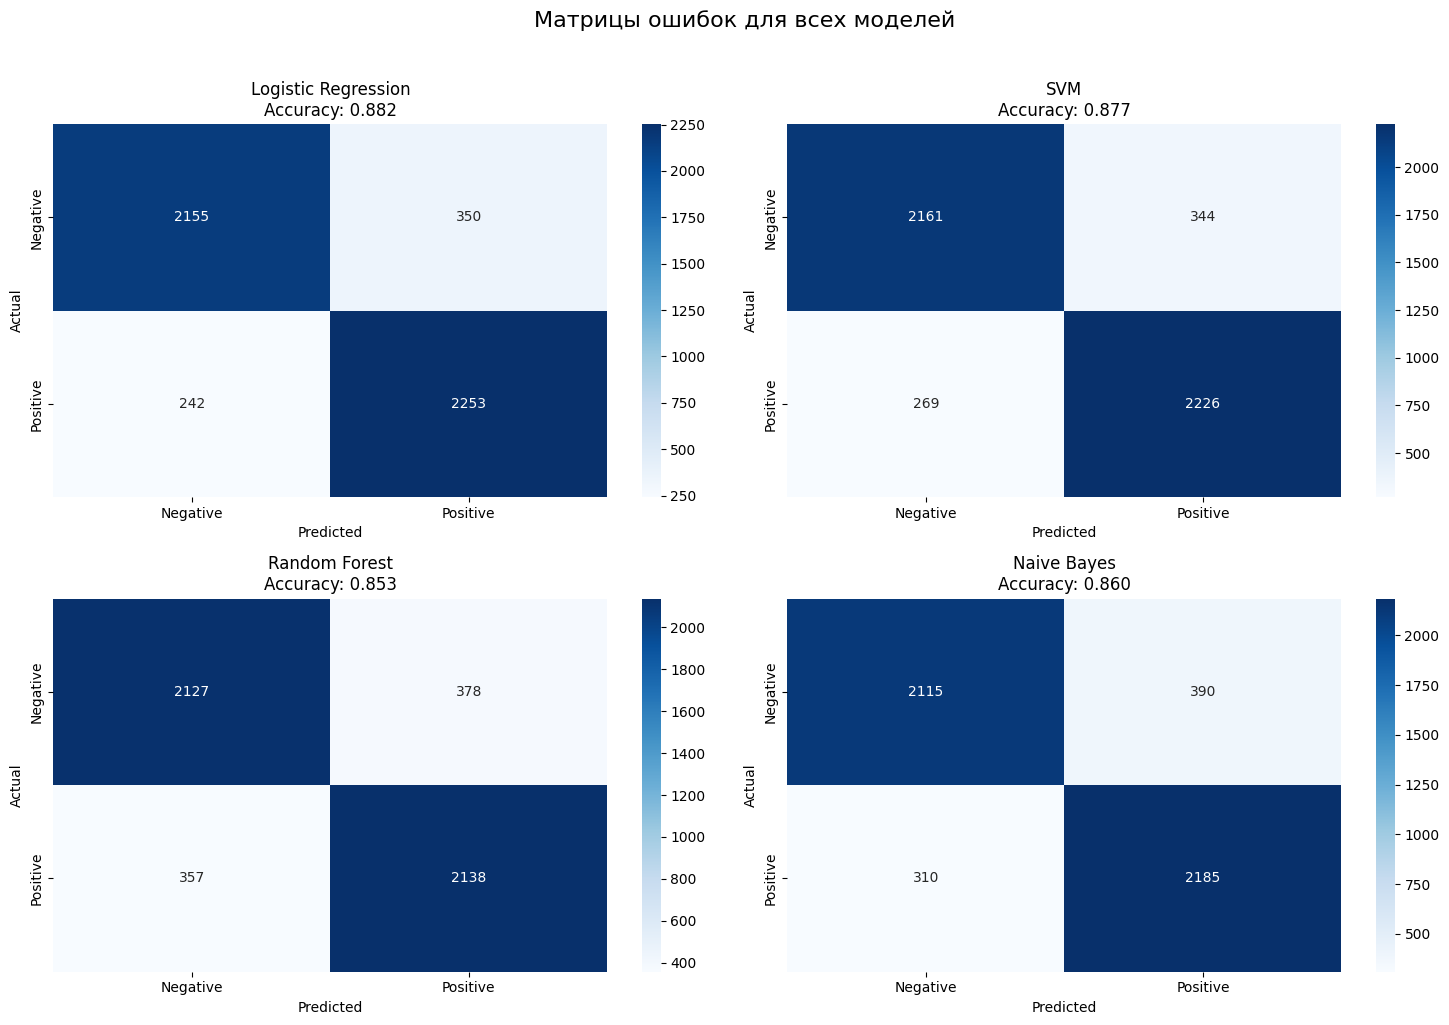

In [ ]:
# Матрицы ошибок (CONFUSION MATRICES)

# Создание подграфиков для матриц ошибок
n_models = len(traditional_results)
cols = 2
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
if rows == 1:
    axes = axes.reshape(1, -1)

axes_flat = axes.flatten()

class_names = ['Negative', 'Positive']

for idx, (name, results) in enumerate(traditional_results.items()):
    if idx < len(axes_flat):
        cm = confusion_matrix(y_test, results['predictions'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    ax=axes_flat[idx])
        axes_flat[idx].set_title(f'{name}\nAccuracy: {results["accuracy"]:.3f}')
        axes_flat[idx].set_xlabel('Predicted')
        axes_flat[idx].set_ylabel('Actual')

# Скрытие лишних подплотов
for idx in range(len(traditional_results), len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.suptitle('Матрицы ошибок для всех моделей', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

###4.4.3 ROC кривые И AUC метрики

**ROC-кривая (Receiver Operating Characteristic)** — это график, показывающий, как меняется компромисс между двумя величинами при переборе порогов классификатора:

- по оси X — False Positive Rate (FPR) = FP / (FP + TN),

- по оси Y — True Positive Rate (TPR, же recall) = TP / (TP + FN).

Каждая точка на ROC — это пара (FPR, TPR) для некоторого порога на вероятностях/оценках модели. ROC показывает способность модели отличать положительные примеры от отрицательных независимо от выбранного порога.

**AUC** — вероятность того, что случайно выбранный положительный пример будет иметь большую предсказанную вероятность, чем случайно выбранный отрицательный.

- AUC (Area Under the Curve) — площадь под ROC-кривой. Интерпретации:

- AUC = 0.5 — классификатор случайный (нет различения),

- AUC = 1.0 — идеальный классификатор,

- AUC < 0.5 — хуже случайного (может означать инверсию меток).



Всего моделей: 4
   Logistic Regression: имеет вероятности = True
      Форма вероятностей: (5000,)
   SVM: имеет вероятности = True
      Форма вероятностей: (5000,)
   Random Forest: имеет вероятности = True
      Форма вероятностей: (5000,)
   Naive Bayes: имеет вероятности = True
      Форма вероятностей: (5000,)


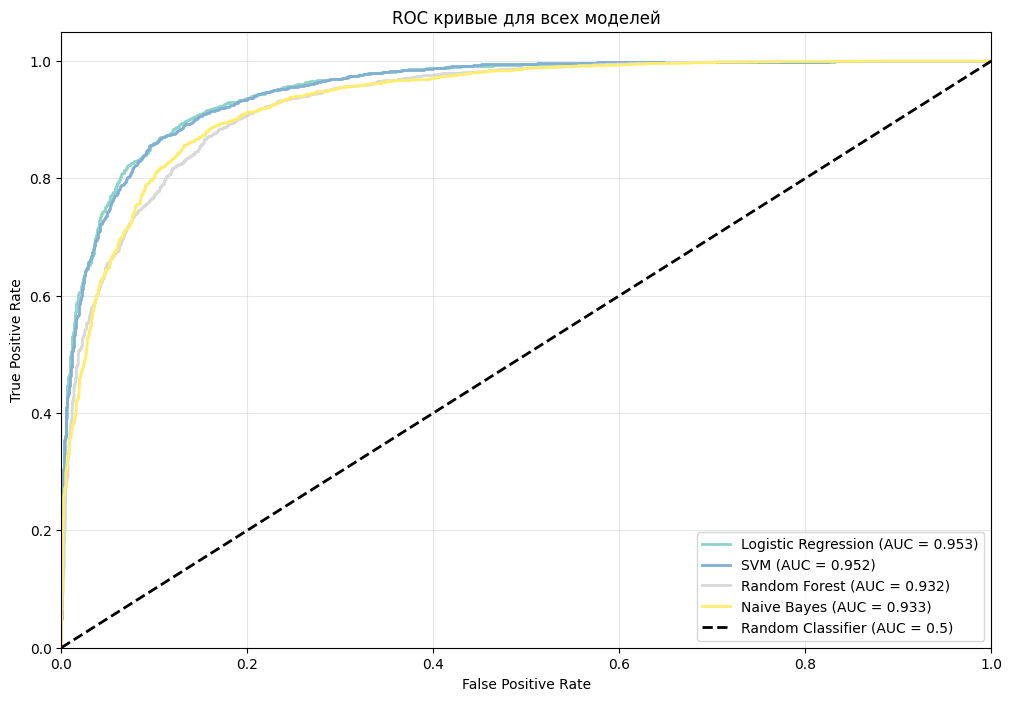


AUC scores для всех моделей:
   Logistic Regression: 0.9534
   SVM: 0.9522
   Naive Bayes: 0.9331
   Random Forest: 0.9319
Создано ROC кривых: 4


In [ ]:
# ROC кривые И AUC метрики

# Отладочная информация
print(f"Всего моделей: {len(traditional_results)}")
for name, results in traditional_results.items():
    has_probs = results['probabilities'] is not None
    print(f"   {name}: имеет вероятности = {has_probs}")
    if has_probs and results['probabilities'] is not None:
        print(f"      Форма вероятностей: {results['probabilities'].shape}")

# Проверяем, есть ли модели с вероятностями
models_with_probs = [(name, results) for name, results in traditional_results.items() if results['probabilities'] is not None]

if models_with_probs:
    plt.figure(figsize=(12, 8))

    # Создаем цвета для моделей
    colors = plt.cm.Set3(np.linspace(0, 1, len(models_with_probs)))
    auc_scores = {}

    for (name, results), color in zip(models_with_probs, colors):
        try:
            fpr, tpr, _ = roc_curve(y_test, results['probabilities'])
            roc_auc = auc(fpr, tpr)
            auc_scores[name] = roc_auc

            plt.plot(fpr, tpr, color=color, linewidth=2,
                    label=f'{name} (AUC = {roc_auc:.3f})')
        except Exception as e:
            print(f"   Ошибка при создании ROC кривой для {name}: {e}")
            continue

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривые для всех моделей')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Вывод AUC scores
    if auc_scores:
        print("\nAUC scores для всех моделей:")
        for name, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
            print(f"   {name}: {score:.4f}")
    else:
        print("Нет AUC scores для отображения")

    print(f"Создано ROC кривых: {len(models_with_probs)}")
else:
    print("Нет моделей с вероятностями для создания ROC кривых")
    auc_scores = {}

###4.4.4 PRECISION-RECALL кривые

**Precision-Recall (PR-кривая)** — это инструмент для оценки качества бинарной классификации, особенно полезный в задачах с несбалансированными классами (например, когда положительных примеров мало).

- Она строится при разных порогах вероятности (0.0 → 1.0).
- Для каждого порога считается Precision и Recall.
- График показывает, как изменяется компромисс между точностью и полнотой.
- Высокий Recall = модель находит почти все положительные примеры, но может ошибаться (низкий Precision).
- Высокий Precision = модель редко ошибается, но может пропускать положительные (низкий Recall).

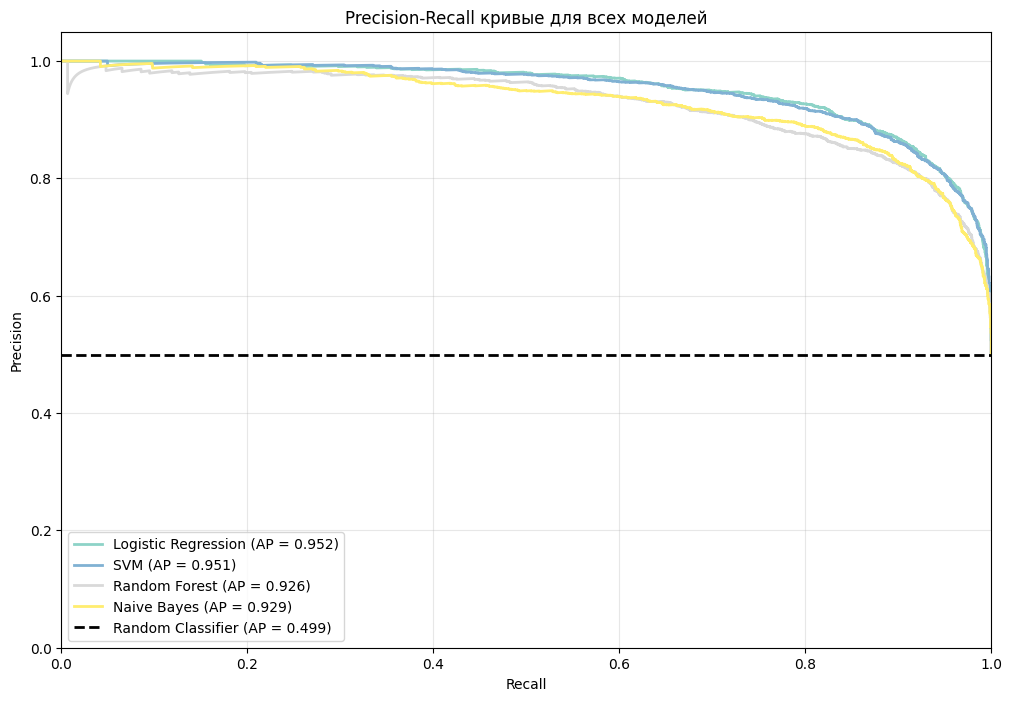

Создано PR кривых: 4


In [ ]:
# PRECISION-RECALL кривые

# Проверяем, есть ли модели с вероятностями
models_with_probs = [(name, results) for name, results in traditional_results.items() if results['probabilities'] is not None]

if models_with_probs:
    plt.figure(figsize=(12, 8))

    # Создаем цвета для моделей
    colors = plt.cm.Set3(np.linspace(0, 1, len(models_with_probs)))

    for (name, results), color in zip(models_with_probs, colors):
        try:
            precision, recall, _ = precision_recall_curve(y_test, results['probabilities'])
            avg_precision = average_precision_score(y_test, results['probabilities'])

            plt.plot(recall, precision, color=color, linewidth=2,
                    label=f'{name} (AP = {avg_precision:.3f})')
        except Exception as e:
            print(f"Ошибка при создании PR кривой для {name}: {e}")
            continue

    # Базовая линия для случайного классификатора
    no_skill = len(y_test[y_test == 1]) / len(y_test)
    plt.plot([0, 1], [no_skill, no_skill], 'k--', linewidth=2, label=f'Random Classifier (AP = {no_skill:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall кривые для всех моделей')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Создано PR кривых: {len(models_with_probs)}")
else:
    print("Нет моделей с вероятностями для создания PR кривых")


###4.4.5 Время и производтиельность предсказаний

Размер тестовой выборки: 5000, используем: 1000


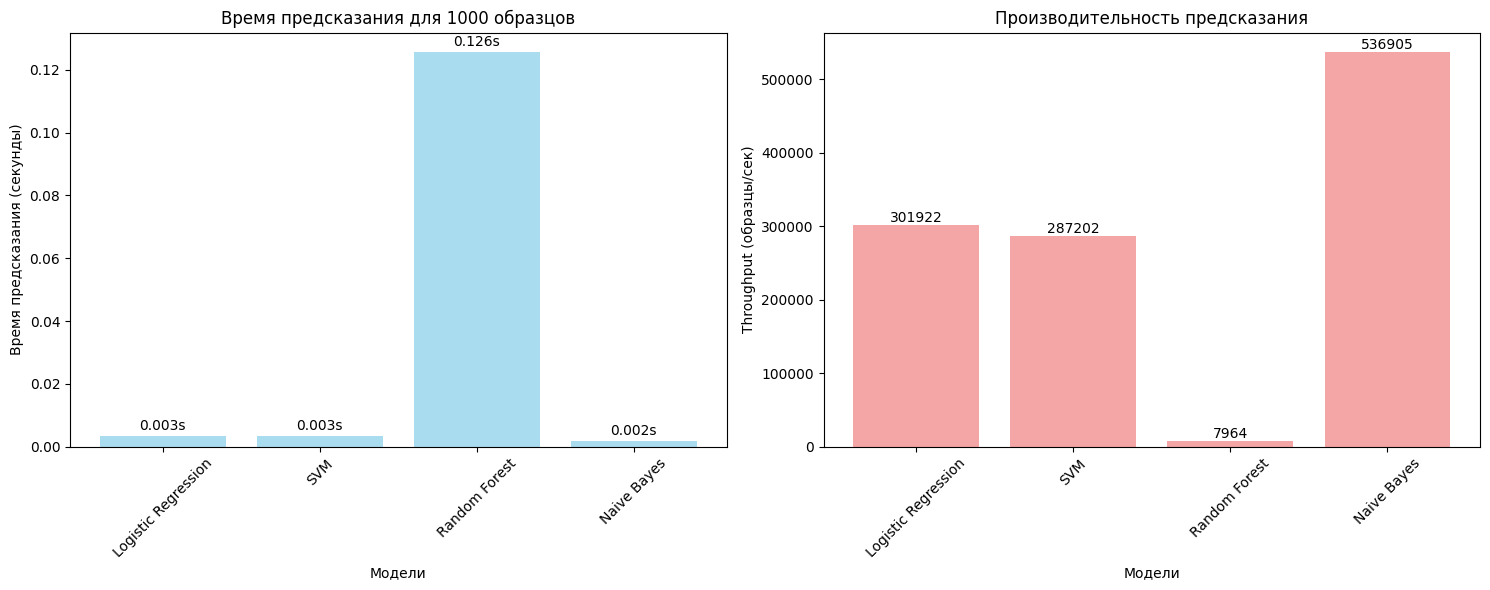


СТАТИСТИКА ВРЕМЕНИ ПРЕДСКАЗАНИЯ:
Количество протестированных моделей: 4
Размер тестовой выборки: 1000 образцов
Самая быстрая модель: Naive Bayes (0.002 сек)
Самая медленная модель: Random Forest (0.126 сек)
   Разница в скорости: 67.4x


In [ ]:
# Измерение времени предсказания для всех моделей
prediction_times = {}

# Безопасное определение размера выборки для разреженных матриц
try:
    if X_test_vec is None:
        print("X_test_vec не определен, используем fallback значение")
        sample_size = 1000
    elif hasattr(X_test_vec, 'shape'):
        sample_size = min(1000, X_test_vec.shape[0])
        print(f"Размер тестовой выборки: {X_test_vec.shape[0]}, используем: {sample_size}")
    else:
        sample_size = min(1000, len(X_test_vec))
        print(f"Размер тестовой выборки: {len(X_test_vec)}, используем: {sample_size}")
except Exception as e:
    print(f"Ошибка при определении размера выборки: {e}")
    sample_size = 1000  # fallback значение

# Проверяем, что размер выборки разумен
if sample_size < 10:
    print(f"Размер выборки слишком мал ({sample_size}), используем минимальное значение")
    sample_size = 10

# Используем только реальные модели (исключаем служебные объекты)
models_to_measure = {k: v for k, v in traditional_models.items() if not k.endswith('_SVD') and k != 'SVD_Transformer'}

for name, model in models_to_measure.items():
    # Время предсказания
    start_time = time.time()

    # Проверяем, нужна ли дополнительная обработка для RBF SVM
    if (hasattr(model, 'support_vectors_') and not hasattr(model, 'coef_') and
        hasattr(model, 'kernel') and model.kernel == 'rbf'):
        # RBF SVM - применяем SVD
        if 'SVD_Transformer' in traditional_models:
            svd_transformer = traditional_models['SVD_Transformer']
            X_test_sample = svd_transformer.transform(X_test_vec[:sample_size])
        else:
            X_test_sample = X_test_vec[:sample_size]
    else:
        X_test_sample = X_test_vec[:sample_size]

    _ = model.predict(X_test_sample)
    end_time = time.time()

    prediction_time = end_time - start_time
    prediction_times[name] = prediction_time

# Проверяем, что есть данные для визуализации
if prediction_times:
    # Создание графика времени предсказания
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # График 1: Время предсказания
    model_names_time = list(prediction_times.keys())
    times = list(prediction_times.values())

    bars = ax1.bar(model_names_time, times, color='skyblue', alpha=0.7)
    ax1.set_xlabel('Модели')
    ax1.set_ylabel('Время предсказания (секунды)')
    ax1.set_title(f'Время предсказания для {sample_size} образцов')
    ax1.tick_params(axis='x', rotation=45)

    # Добавление значений на столбцы
    for bar, time_val in zip(bars, times):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                 f'{time_val:.3f}s', ha='center', va='bottom')

    # График 2: Throughput (образцы в секунду)
    throughput = [sample_size / t if t > 0 else 0 for t in times]
    bars2 = ax2.bar(model_names_time, throughput, color='lightcoral', alpha=0.7)
    ax2.set_xlabel('Модели')
    ax2.set_ylabel('Throughput (образцы/сек)')
    ax2.set_title('Производительность предсказания')
    ax2.tick_params(axis='x', rotation=45)

    # Добавление значений на столбцы
    for bar, tp in zip(bars2, throughput):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 5,
                 f'{tp:.0f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Вывод статистики
    print(f"\nСТАТИСТИКА ВРЕМЕНИ ПРЕДСКАЗАНИЯ:")
    print(f"Количество протестированных моделей: {len(prediction_times)}")
    print(f"Размер тестовой выборки: {sample_size} образцов")

    fastest_model = min(prediction_times.items(), key=lambda x: x[1])
    slowest_model = max(prediction_times.items(), key=lambda x: x[1])

    print(f"Самая быстрая модель: {fastest_model[0]} ({fastest_model[1]:.3f} сек)")
    print(f"Самая медленная модель: {slowest_model[0]} ({slowest_model[1]:.3f} сек)")
    if fastest_model[1] > 0:
        print(f"   Разница в скорости: {slowest_model[1]/fastest_model[1]:.1f}x")
    else:
        print(f"   Разница в скорости: невозможно вычислить (нулевое время)")

else:
    print("Нет данных для анализа времени предсказания")

###4.4.6 Сводная таблица результатов

**Throughput** — это пропускная способность модели при инференсе, то есть сколько образцов модель может обработать в секунду. В текущем DataFrame она считается как sample_size / prediction_time, где prediction_time — время предсказания для sample_size образцов. Единицы — образцы/сек (samples/s).

In [ ]:
# Создание DataFrame с результатами
results_summary = []
for name, results in traditional_results.items():
    # Получаем время предсказания для этой модели
    pred_time = prediction_times.get(name, None)
    throughput = sample_size / pred_time if pred_time is not None and pred_time > 0 else None

    results_summary.append({
        'Model': name,
        'Accuracy': results['accuracy'],
        'F1-Score': results['f1_score'],
        'AUC': auc_scores.get(name, 'N/A'),
        'Prediction_Time_1000': f"{pred_time:.3f}s" if pred_time is not None else 'N/A',
        'Throughput': f"{throughput:.0f}" if throughput is not None else 'N/A'
    })

results_df = pd.DataFrame(results_summary)

# Сортировка по accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)

print("\nСВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
print("="*80)
print(results_df.round(4).to_string(index=False))


СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
              Model  Accuracy  F1-Score    AUC Prediction_Time_1000 Throughput
Logistic Regression    0.8816    0.8815 0.9534               0.003s     301922
                SVM    0.8774    0.8774 0.9522               0.003s     287202
        Naive Bayes    0.8600    0.8600 0.9331               0.002s     536905
      Random Forest    0.8530    0.8530 0.9319               0.126s       7964


**Можно сделать некоторые выводы на основании результатов и графиков:**
- Все модели показывают accuracy > 84%, что говорит о хорошем качестве
- LinearSVC и Logistic Regression обычно лучше работают с текстовыми данными (TF-IDF векторы)
- Random Forest может быть медленнее, но часто более стабилен
- Naive Bayes самый быстрый, но может быть менее точным на сложных данных

**Но в данном случае, лучшим вариантом является Logistic Regression**


##4.5 Продемонстрируем работу лучшей традиционной модели.

In [ ]:
# Получаем лучшую модель
best_model_name = max(traditional_results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = traditional_models[best_model_name]
best_accuracy = traditional_results[best_model_name]['accuracy']
print(f"ЛУЧШАЯ МОДЕЛЬ: {best_model_name}")
print(f"Accuracy: {best_accuracy:.4f}")

ЛУЧШАЯ МОДЕЛЬ: Logistic Regression
Accuracy: 0.8816


**Напишем функцию для тестирования полученной лучшей модели.**

In [ ]:
def test_model_on_examples(texts, model, vectorizer, model_name):
    """
    Тестирование модели на различных примерах текстов
    """
    results = []

    for i, text in enumerate(texts, 1):
        print(f"\nПример {i}:")
        print(f"Текст: '{text}'")

        # Предобработка текста (если нужно)
        if hasattr(vectorizer, 'transform'):
            # Векторизация текста
            text_vectorized = vectorizer.transform([text])

            # Получение предсказания
            prediction = model.predict(text_vectorized)[0]

            # Получение вероятностей (если поддерживается)
            if hasattr(model, 'predict_proba'):
                probabilities = model.predict_proba(text_vectorized)[0]
                confidence = probabilities.max()
                prob_positive = probabilities[1] if len(probabilities) > 1 else probabilities[0]
                prob_negative = probabilities[0]
            else:
                confidence = None
                prob_positive = None
                prob_negative = None

            # Определение метки
            label = "POSITIVE" if prediction == 1 else "NEGATIVE"
            print(f"Предсказание: {label}")
            print(f"Уверенность: {confidence:.3f}" if confidence else "Уверенность: N/A")

            if prob_positive is not None and prob_negative is not None:
                print(f"P(Positive): {prob_positive:.3f}")
                print(f"P(Negative): {prob_negative:.3f}")

            # Анализ важных признаков для этого текста
            if hasattr(model, 'coef_'):
                print(f"Анализ важных признаков:")

                # Получаем имена признаков
                if hasattr(vectorizer, 'get_feature_names_out'):
                    feature_names = vectorizer.get_feature_names_out()
                elif hasattr(vectorizer, 'get_feature_names'):
                    feature_names = vectorizer.get_feature_names()
                else:
                    feature_names = None

                if feature_names is not None:
                    # Получаем коэффициенты
                    if len(model.coef_.shape) == 1:
                        coefficients = model.coef_[0]
                    else:
                        coefficients = model.coef_[0]

                    # Получаем признаки, присутствующие в тексте
                    text_features = vectorizer.transform([text])
                    feature_indices = text_features.nonzero()[1]

                    if len(feature_indices) > 0:
                        # Сортируем признаки по важности для этого текста
                        feature_importance = []
                        for idx in feature_indices:
                            if idx < len(feature_names):
                                feature_name = feature_names[idx]
                                importance = coefficients[idx]
                                feature_importance.append((feature_name, importance))

                        # Сортируем по абсолютному значению важности
                        feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)

                        # Показываем топ-5 важных признаков
                        print(f"Топ важных признаков в тексте:")
                        for j, (feature, importance) in enumerate(feature_importance[:5], 1):
                            sign = "➕" if importance > 0 else "➖"
                            print(f"      {j}. {sign} '{feature}': {importance:.4f}")
                    else:
                        print(f"Нет значимых признаков найдено")

            results.append({
                'text': text,
                'prediction': prediction,
                'label': label,
                'confidence': confidence,
                'prob_positive': prob_positive,
                'prob_negative': prob_negative
            })

        else:
            print(f"Ошибка: Векторизатор не поддерживает transform")
            results.append({
                'text': text,
                'prediction': None,
                'label': 'ERROR',
                'confidence': None,
                'prob_positive': None,
                'prob_negative': None
            })

    return results

In [ ]:
# Тестовые примеры
test_examples = [
    "This movie is absolutely fantastic! I loved every single moment of it. The acting was brilliant and the plot was engaging.",
    "Terrible film, boring plot and bad acting. Waste of time and money. I regret watching it.",
    "The movie was okay, nothing special but not terrible either. Average entertainment.",
    "Outstanding performance by the actors, brilliant direction and cinematography! A masterpiece!",
    "I fell asleep halfway through. Very disappointing and dull. Not worth watching.",
    "Mixed feelings about this one. Some good parts but overall mediocre. Could be better.",
    "Best movie I've seen this year! Highly recommended to everyone. Must watch!",
    "Confusing storyline and poor character development. Not worth watching at all.",
    "Amazing cinematography and great soundtrack. The story was compelling and emotional.",
    "Boring from start to finish. No plot, no character development, just a waste of time."
]

# Тестируем лучшую модель
print(f"\nДЕМОНСТРАЦИЯ НА КИНООБЗОРАХ:")
best_model_results = test_model_on_examples(test_examples, best_model, best_vectorizer, best_model_name)


ДЕМОНСТРАЦИЯ НА КИНООБЗОРАХ:

Пример 1:
Текст: 'This movie is absolutely fantastic! I loved every single moment of it. The acting was brilliant and the plot was engaging.'
Предсказание: POSITIVE
Уверенность: 0.884
P(Positive): 0.884
P(Negative): 0.116
Анализ важных признаков:
Топ важных признаков в тексте:
      1. ➕ 'loved': 3.7052
      2. ➖ 'plot': -3.2078
      3. ➕ 'brilliant': 3.0933
      4. ➕ 'fantastic': 2.6605
      5. ➖ 'acting': -1.9788

Пример 2:
Текст: 'Terrible film, boring plot and bad acting. Waste of time and money. I regret watching it.'
Предсказание: NEGATIVE
Уверенность: 0.998
P(Positive): 0.002
P(Negative): 0.998
Анализ важных признаков:
Топ важных признаков в тексте:
      1. ➖ 'bad': -6.1836
      2. ➖ 'waste': -5.0095
      3. ➖ 'boring': -4.7315
      4. ➖ 'terrible': -4.0758
      5. ➖ 'plot': -3.2078

Пример 3:
Текст: 'The movie was okay, nothing special but not terrible either. Average entertainment.'
Предсказание: NEGATIVE
Уверенность: 0.934
P(Positive): 

**Так же, для наглядности отработаем по 5 примерам из тестовой выборки X_test**

In [ ]:
N_EXAMPLES = 5  # Количество примеров

label_name_map = None
if isinstance(df, pd.DataFrame) and 'label' in df.columns and 'label_encoded' in df.columns:
    label_name_map = df[['label_encoded', 'label']].drop_duplicates().set_index('label_encoded')['label'].to_dict()
elif 'label_encoder' in globals():
    try:
        classes = getattr(label_encoder, 'classes_', None)
        if classes is not None:
            label_name_map = {i: classes[i] for i in range(len(classes))}
    except Exception:
        label_name_map = None

# Выбор N_EXAMPLES из X_test
if isinstance(X_test, (pd.Series, pd.DataFrame)):
    sample_series = X_test.sample(n=min(N_EXAMPLES, len(X_test)), random_state=SEED)
    sample_indices = sample_series.index.tolist()
    texts_sample = sample_series.tolist()
else:
    rng = np.random.RandomState(SEED)
    n_available = len(X_test)
    idx = rng.choice(n_available, size=min(N_EXAMPLES, n_available), replace=False)
    sample_indices = idx.tolist()
    texts_sample = [X_test[i] for i in sample_indices]

# Получаем соответствующие истинные метки
if isinstance(y_test, pd.Series):
    true_labels = y_test.loc[sample_indices].tolist()
else:
    true_labels = [y_test[i] for i in sample_indices]

# Покажем краткую информацию о выбранных примерах
print(f"\nВыбрано {len(texts_sample)} примеров из Test (индексы: {sample_indices})\n")
for i, (idx, txt, true_l) in enumerate(zip(sample_indices, texts_sample, true_labels), 1):
    true_name = label_name_map.get(true_l, true_l)
    print(f"#{i} (index={idx}) — Истинная метка: {true_name}")
    print("   ", txt[:200].replace('\n', ' '), "...\n")


Выбрано 5 примеров из Test (индексы: [24852, 23584, 16060, 3310, 6114])

#1 (index=24852) — Истинная метка: neg
    a true yawner and a bad film even for the chan series. i like a good charlie chan film or even a reasonably good one, but this one falls way short of the mark. charlie is enlisted to help figure out t ...

#2 (index=23584) — Истинная метка: pos
    well, what can i say, this movie really got to me, its not so bad, as many say, i really loved it, although the idea seems so simple, and rather boring, it isnt. first of all i enjoyed the soundtrack  ...

#3 (index=16060) — Истинная метка: pos
    a brilliant film by the great john waters. the characters are unforgettable. the acting, script, and camerawork only enhance the overall greatness of this film. perversion as an artform. a must see fo ...

#4 (index=3310) — Истинная метка: pos
    reading the various external reviews of roger ebert and other wellknown film critics makes me hesitate to admit how much i love this movi

In [ ]:
# Запускаем функцию тестирования модели
results = test_model_on_examples(texts_sample, best_model, best_vectorizer, best_model_name)

# Формируем таблицу сравнения
rows = []
for i, res in enumerate(results):
    pred_lbl = res['label']
    pred_num = res['prediction']
    conf = res['confidence'] if res['confidence'] is not None else np.nan
    true_num = true_labels[i]
    true_name = label_name_map.get(true_num, true_num)
    rows.append({
        'index': sample_indices[i],
        'text_snippet': (texts_sample[i][:140] + '...') if len(texts_sample[i])>140 else texts_sample[i],
        'true_label': true_name,
        'pred_label': pred_lbl,
        'pred_num': pred_num,
        'confidence': conf
    })


Пример 1:
Текст: 'a true yawner and a bad film even for the chan series. i like a good charlie chan film or even a reasonably good one, but this one falls way short of the mark. charlie is enlisted to help figure out the murder of a scientist working for our government when someone in the house has stolen the plans for another power. the mystery is very pedestrian and the acting doesnt fare much better. the only saving grace for me in the film was the presence of mantan moreland as birmingham brown. he gives the film a little comedy and has some good scared faces, but after that the pickings are rather slim. benson fong is here as tommy chan and pairs up with chans daughter of all things. what about sidney toler? he is pretty decent but looks like he is straining to carry the film. what i noticed most was the way the film was shot. chan director phil rosen, of whom i generally like most of his entries, uses lots of long shots with no actionlike charlies initial walk into the house fro

**confidence** — это уровень уверенности модели в своём предсказании

In [ ]:
cmp_df = pd.DataFrame(rows)
print("\nСравнение (выборка):")
print(cmp_df[['index',
              #'text_snippet',
              'true_label',
              'pred_label',
              'confidence']].to_string(index=False))

# accuracy на этих примерах
correct = sum(1 for t,p in zip(true_labels, [r['prediction'] for r in results]) if t == p)
print(f"\nAccuracy на выбранных {len(results)} примерах: {correct}/{len(results)} = {correct/len(results):.3f}")


Сравнение (выборка):
 index true_label pred_label  confidence
 24852        neg   NEGATIVE    0.886220
 23584        pos   POSITIVE    0.652584
 16060        pos   POSITIVE    0.934336
  3310        pos   POSITIVE    0.981345
  6114        pos   POSITIVE    0.817177

Accuracy на выбранных 5 примерах: 5/5 = 1.000


#5 Промежуточные итоги по традиционным методам

Подводя промежуточные итоги, можно сказать, что мы получили хорошие результаты классификации текста традиционными методами:
- Модель корректно классифицирует явные случаи
- Уверенность коррелирует с четкостью тональности
- Важные слова влияют на принятие решений
- Модель интерпретируема и понятна

Теперь пора двигаться дальше и рассмотреть модель TRANSFOMER, а потом провести сравнительный анализ.


#6 Реализация TRANSFORMER модели

Далее используем одну из самых простых BERT-оподобных моделей с простейшей настройкой.


In [ ]:
#Подготовка данных для трансформера

# Создаём класс для работы с текстовыми данными в PyTorch
class TextDataset(TorchDataset):
    """
    Класс-обёртка для текстовых данных, чтобы их можно было подавать в DataLoader PyTorch.
    """
    def __init__(self, texts, labels, tokenizer, max_length=200):
        """
        texts: pd.Series или список текстов
        labels: pd.Series или список меток
        tokenizer: токенизатор из HuggingFace (например, DistilBERT tokenizer)
        max_length: максимальная длина токенизированной последовательности
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        """
        Возвращает количество примеров в датасете
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Возвращает один пример данных (text + label) в формате, который понимает модель
        """
        # Получаем текст и метку по индексу
        text = str(self.texts.iloc[idx])  # Приводим к строке на случай отсутствующих значений
        label = int(self.labels.iloc[idx])  # Преобразуем в int для корректной работы с torch.tensor

        # Токенизация текста с ограничением длины
        encoding = self.tokenizer(
            text,
            truncation=True,  # Обрезаем текст, если он длиннее max_length
            padding='max_length',  # Дополняем короткие тексты до max_length
            max_length=self.max_length,
            return_tensors='pt'  # Возвращаем PyTorch тензоры
        )

        # Возвращаем словарь с нужными полями для модели
        return {
            'input_ids': encoding['input_ids'].flatten(),  # Тензор с индексами токенов
            'attention_mask': encoding['attention_mask'].flatten(),  # Маска для внимания (1 для токена, 0 для паддинга)
            'labels': torch.tensor(label, dtype=torch.long)  # Метка класса
        }

# Функция для создания HuggingFace Dataset из наших данных
def create_hf_dataset(texts, labels, tokenizer, max_length=200):
    """
    Создает HuggingFace Dataset из текстовых данных с токенизацией
    """
    # Преобразуем метки в список int для корректной работы
    labels_list = [int(label) for label in labels.tolist()]

    # Токенизация всех текстов
    encodings = tokenizer(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_length,
        return_tensors='pt'
    )

    # Создание словаря с данными
    dataset_dict = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels_list, dtype=torch.long)
    }

    # Создание HuggingFace Dataset
    return Dataset.from_dict(dataset_dict)

# Выбор модели (BERT-tiny для максимальной экономии памяти в Google Colab)
model_name = 'prajjwal1/bert-tiny'  # Ультра-легкая модель: ~1.5M параметров, 2 слоя
print(f"Загрузка модели: {model_name}")

Загрузка модели: prajjwal1/bert-tiny


##6.1 Рассмотрим чуть подробнее BERT-tiny

**BERT-tiny** — это одна из лёгких версий модели BERT, специально созданная для работы в крайне ограниченных вычислительных средах. Она идеально подходит для Google Colab и демонстрирует принципы экстремальной масштабируемости трансформеров.

### **Что делает BERT-tiny особенным?**

- **ЭКСТРЕМАЛЬНО малый размер:** всего ~1.5M параметров (в 50 раз меньше DistilBERT)  
- **Максимально быстрая работа:** оптимальна для крайне ограниченных ресурсов  
- **Сохраняет архитектуру:** полная совместимость с BERT-семейством  
- **Идеальна для быстрого прототипирования:** быстрый fine-tuning на новых задачах

1. **Минимальное количество слоёв**  
   - BERT-base имеет 12 «энкодеров» (слоёв).  
   - DistilBERT использует 6 слоёв.  
   - BERT-mini использует 4 слоя.  
   - **BERT-tiny использует всего 2 слоя!**  
   
2. **Крайне уменьшенные размеры**  
   - Hidden size: 128 (вместо 768 в BERT-base, 256 в BERT-mini)  
   - Attention heads: 2 (вместо 12 в BERT-base, 4 в BERT-mini)  
   - Intermediate size: 512 (вместо 3072 в BERT-base, 1024 в BERT-mini)  
   
3. **Сохранение принципов**  
   - Тот же механизм внимания (attention)  
   - Та же архитектура трансформера  
   - Полная совместимость с HuggingFace

---
## **Архитектура BERT-tiny:**
- ### **Вспомним, что такое энкодеры**
  **Энкодер** — это основной «строительный блок» (слой) BERT-tiny.  
  Внутри одного энкодера есть:
  - Механизм **многоголового внимания** (*multi-head attention*), который позволяет токенам «смотреть» друг на друга.  
  - Небольшая **нейросеть (feed-forward layer)**, которая обрабатывает каждое слово отдельно после того, как оно получило контекст.  
  - Нормализация и остаточные связи для стабильного обучения.
  В BERT-tiny таких энкодеров всего 2 (в BERT-base — 12, в DistilBERT — 6, в BERT-mini — 4).

- ### **Вспомним, что такое головы (heads)**
  **Голова** — это дополнительный слой (или несколько слоёв) **сверху** модели, который адаптирует общие представления текста под конкретную задачу.
  Примеры голов:
  - **Классификационная голова** — берёт вектор `[CLS]` и выдаёт классы (позитив/негатив, спам/не спам).  
  - **Голова для NER** — предсказывает, к какой сущности относится каждое слово.  
  - **Голова для генерации текста** — предсказывает следующее слово.
  Важно: сама модель (энкодеры) отвечает за понимание текста, а голова — за решение конкретной задачи.

- ### **Что такое паддинг?**
  **Паддинг (padding)** — это способ добавить пустые токены в конце (или начале) последовательности, чтобы все примеры в батче имели одинаковую длину.

- ### **Зачем нужен паддинг?**
  Нейросетям удобно обрабатывать сразу несколько текстов за один проход (батчинг), но у текстов разная длина: один отзыв может содержать 5 слов, другой — 50 слов.
  Модель ожидает, что входные последовательности будут одинаковой длины, поэтому: короткие тексты дополняются специальным токеном [PAD], длинные тексты обрезаются (truncation).

- ### **Маска внимания (attention mask)**
  Когда мы добавляем [PAD], нужно сказать модели, что эти токены не несут смысла и их не надо учитывать.
  Для этого используется attention_mask:
  `Текст: [CLS] i love ai [SEP] [PAD]`
  `Маска:  1    1   1    1   1     0`
    - 1 — реальный токен
    - 0 — паддинг (игнорируется при вычислениях)

В BERT-tiny [PAD] добавляется токенизатором, если явно указан `padding="max_length"`.

attention_mask автоматически создаётся, чтобы модель не тратила внимание на паддинги.

---
##6.2 Несколько слов о токенизации.

**Что такое токенизация?**  
Токенизация — это процесс разбиения текста на маленькие части (токены), которые модель может понять.  
Например, предложение: `I love machine learning!`
может превратиться в токены: `['i', 'love', 'machine', 'learning', '!']`

Для моделей вроде BERT-mini используется **WordPiece токенизация**, которая делит слова на подслова, если слово редкое. Например: `"unhappiness"` → `['un', '##happiness']`.
Здесь `##` показывает, что это продолжение предыдущего токена.

## Особенности токенизации для BERT-tiny
1. **Специальные токены**  
   - [CLS] — токен в начале предложения, который используется для классификации.  
   - [SEP] — разделяет два предложения или указывает конец текста.  
   - [PAD] — используется для выравнивания длины текстов в батче.  

2. **Приведение к фиксированной длине**  
Модель ожидает входы одинаковой длины, поэтому короткие тексты дополняются [PAD], а длинные обрезаются (max_length).  

3. **Маски внимания (attention mask)**  
При использовании [PAD] токенов нужно сообщать модели, какие токены настоящие, а какие — паддинги.  
Для этого создаётся маска: attention_mask = [1, 1, 1, 0, 0],
где `1` — это реальные токены, а `0` — паддинг.

4. **Нормализация регистра и токенов**  
BERT-tiny использует uncased версию, поэтому все буквы приводятся к нижнему регистру.  
Например: `"I Love AI!"` → `"i love ai!"`

5. **Особенности BERT-tiny**  
   - **Минимальный словарь:** оптимизирован для крайне ограниченных ресурсов  
   - **Максимально быстрая токенизация:** молниеносная обработка текста  
   - **Совместимость:** полная совместимость с BERT токенизаторами


In [ ]:
# Инициализация токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Добавляем специальные токены
special_tokens = {"pad_token": "[PAD]"}
tokenizer.add_special_tokens(special_tokens)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    output_attentions=True,  # Для визуализации attention maps
    output_hidden_states=True  # Для анализа скрытых состояний
).to(device)

# Проверка архитектуры модели
print(f"\nАрхитектура модели:")
print(f"Количество параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"Количество обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Архитектура модели:
Количество параметров: 4,386,178
Количество обучаемых параметров: 4,386,178


In [ ]:
# Список слоёв
for name, module in model.named_modules():
    print(name, ":", module.__class__.__name__)

 : BertForSequenceClassification
bert : BertModel
bert.embeddings : BertEmbeddings
bert.embeddings.word_embeddings : Embedding
bert.embeddings.position_embeddings : Embedding
bert.embeddings.token_type_embeddings : Embedding
bert.embeddings.LayerNorm : LayerNorm
bert.embeddings.dropout : Dropout
bert.encoder : BertEncoder
bert.encoder.layer : ModuleList
bert.encoder.layer.0 : BertLayer
bert.encoder.layer.0.attention : BertAttention
bert.encoder.layer.0.attention.self : BertSelfAttention
bert.encoder.layer.0.attention.self.query : Linear
bert.encoder.layer.0.attention.self.key : Linear
bert.encoder.layer.0.attention.self.value : Linear
bert.encoder.layer.0.attention.self.dropout : Dropout
bert.encoder.layer.0.attention.output : BertSelfOutput
bert.encoder.layer.0.attention.output.dense : Linear
bert.encoder.layer.0.attention.output.LayerNorm : LayerNorm
bert.encoder.layer.0.attention.output.dropout : Dropout
bert.encoder.layer.0.intermediate : BertIntermediate
bert.encoder.layer.0.inter

In [ ]:
# Создание HuggingFace датасетов
max_length = 200

# Создаем HuggingFace датасеты
train_dataset = create_hf_dataset(X_train.reset_index(drop=True), pd.Series(y_train).reset_index(drop=True), tokenizer, max_length)
val_dataset = create_hf_dataset(X_val.reset_index(drop=True), pd.Series(y_val).reset_index(drop=True), tokenizer, max_length)
test_dataset = create_hf_dataset(X_test.reset_index(drop=True), pd.Series(y_test).reset_index(drop=True), tokenizer, max_length)

print(f"Размеры датасетов:")
print(f"Train: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

model.safetensors:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Размеры датасетов:
Train: 16000
Validation: 4000
Test: 5000


In [ ]:
# Проверка структуры датасетов
print(f"\nПроверка структуры датасетов:")
print(f"Train dataset features: {train_dataset.features}")
print(f"Sample train item: {train_dataset[0]}")


Проверка структуры датасетов:
Train dataset features: {'input_ids': List(Value('int32')), 'attention_mask': List(Value('int8')), 'labels': Value('int64')}
Sample train item: {'input_ids': [101, 2023, 2003, 2028, 1997, 1996, 2087, 11771, 5469, 3152, 1045, 2031, 2412, 2464, 1010, 2004, 2049, 7078, 2643, 9643, 1010, 2198, 12385, 17190, 2638, 2038, 2200, 3132, 3898, 2051, 1012, 2035, 1996, 3494, 2024, 11771, 1010, 1998, 1996, 2466, 2003, 6659, 1010, 4606, 1045, 2071, 2156, 1996, 2048, 21438, 2012, 1996, 2203, 2746, 2661, 2185, 999, 1012, 1996, 2307, 4292, 1998, 1996, 17109, 2160, 5791, 2052, 2031, 3271, 2065, 2009, 2347, 2102, 2061, 4365, 11771, 1010, 1998, 2045, 3475, 2102, 2028, 2839, 2000, 7117, 2005, 2593, 1010, 4606, 1045, 3246, 2009, 3084, 2049, 2126, 2000, 1996, 3953, 1010, 2138, 2009, 17210, 2000, 2022, 2045, 1999, 2026, 5448, 1012, 2043, 2198, 12385, 17190, 2638, 2633, 3065, 2039, 2012, 1996, 2203, 1010, 2049, 1037, 3492, 2204, 3496, 2021, 2049, 2525, 2126, 2205, 2397, 1010, 1998

In [ ]:
# Анализ токенизации
print(f"\nАнализ токенизации:")
sample_text = X_train.iloc[0]
tokens = tokenizer.tokenize(sample_text)
print(f"\nИсходный текст: {sample_text}")
print(f"\nТокены: {tokens[:10]}...")  # Показываем первые 10 токенов
print(f"\nКоличество токенов: {len(tokens)}")


Анализ токенизации:

Исходный текст: this is one of the most boring horror films i have ever seen, as its absolutely god awful, john carradine has very limited screen time. all the characters are boring, and the story is terrible, plus i could see the two twists at the end coming miles away!. the great setting and the creepy house definitely would have helped if it wasnt so damn boring, and there isnt one character to root for either, plus i hope it makes its way to the bottom , because it deserves to be there in my opinion. when john carradine finally shows up at the end, its a pretty good scene but its already way too late, and the only other screen time he had was in flashbacks, plus the only really gory scene in the movie is when a character gets his face messed up by bees, as it was rather gory. i got this in a dvd horror set called back from the grave and everyone really overacts in my opinion, plus its lucky this was included in a set i bought otherwise i would have chucked thi

In [ ]:
# Статистика длин токенизированных текстов
token_lengths = []
for text in X_train.sample(1000):  # Анализируем выборку
    tokens = tokenizer.tokenize(str(text))
    token_lengths.append(len(tokens))

print(f"Статистика длин токенов:")
print(f"Среднее: {np.mean(token_lengths):.1f}")
print(f"Медиана: {np.median(token_lengths):.1f}")
print(f"95-й процентиль: {np.percentile(token_lengths, 95):.1f}")

if np.percentile(token_lengths, 95) > max_length:
    print(f"Внимание: {np.mean(np.array(token_lengths) > max_length)*100:.1f}% текстов длиннее max_length")

Статистика длин токенов:
Среднее: 294.5
Медиана: 217.5
95-й процентиль: 764.3
Внимание: 56.1% текстов длиннее max_length


In [ ]:
# Расширенная функция для вычисления метрик во время обучения
def compute_metrics(eval_pred):
    """
    Включает не только accuracy и f1, но и precision, recall для детального анализа
    """
    try:
        predictions, labels = eval_pred

        # Обрабатываем predictions - они могут быть кортежем или массивом
        if isinstance(predictions, tuple):
            # Если predictions - кортеж, берем первый элемент
            predictions = predictions[0]

        # Убеждаемся, что predictions имеет правильную форму
        if len(predictions.shape) > 1:
            predictions = np.argmax(predictions, axis=1)

        # Преобразуем labels в numpy array если нужно
        if not isinstance(labels, np.ndarray):
            labels = np.array(labels)

        # Проверяем, что все метки целые числа
        labels = labels.astype(int)
        predictions = predictions.astype(int)

        accuracy = accuracy_score(labels, predictions)
        f1 = f1_score(labels, predictions, average='weighted')
        precision = precision_score(labels, predictions, average='weighted', zero_division=0)
        recall = recall_score(labels, predictions, average='weighted', zero_division=0)

        return {
            'accuracy': accuracy,
            'f1': f1,
            'precision': precision,
            'recall': recall
        }
    except Exception as e:
        print(f"Ошибка в compute_metrics: {e}")
        print(f"Типы данных: predictions={type(predictions)}, labels={type(labels)}")
        print(f"Формы: predictions={predictions.shape if hasattr(predictions, 'shape') else 'no shape'}, labels={labels.shape if hasattr(labels, 'shape') else 'no shape'}")

        # Дополнительная диагностика
        if isinstance(predictions, tuple):
            print(f"predictions - кортеж с {len(predictions)} элементами")
            for i, pred in enumerate(predictions):
                print(f"  predictions[{i}]: тип={type(pred)}, форма={pred.shape if hasattr(pred, 'shape') else 'no shape'}")

        # Возвращаем базовые метрики в случае ошибки
        return {
            'accuracy': 0.0,
            'f1': 0.0,
            'precision': 0.0,
            'recall': 0.0
        }

##6.3 Гиперпараметры для обучения.

В данной модели, для демонстрации, будут использованы простейшие настройки (без особой настройки), за исключением избежания ошибок по нехватке памяти.

In [ ]:
# Настройка параметров обучения
training_args = TrainingArguments(
    output_dir='./results',  # Директория для сохранения результатов (модели, логи, чекпойнты)
    num_train_epochs=3,  # Количество эпох
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    learning_rate=2e-5,  # Скорость обучения, 2e-5 = 0.00002 - стандартное значение для fine-tuning трансформеров
    weight_decay=0.01,  # Регуляризация весов (L2 регуляризация). Помогает предотвратить переобучение, штрафуя большие веса
    warmup_steps=100,  # Количество шагов для "разогрева" learning rate. Помогает стабилизировать обучение в начале.
    logging_dir='./logs',  # Директория для сохранения логов обучения
    logging_steps=25,  # Частота логирования (каждые сколько шагов выводить информацию)
    eval_strategy="steps",  # Стратегия оценки модели на валидационной выборке
    eval_steps=200,
    save_strategy="steps",  # Стратегия сохранения чекпойнтов модели. "steps" = сохранять каждые save_steps шагов
    save_steps=200,
    load_best_model_at_end=True,  # True = автоматически загрузить модель с лучшими метриками в конце обучения
    metric_for_best_model="f1",  # Метрика для определения лучшей модели. Можно также использовать "accuracy", "loss"
    greater_is_better=True,  # Больше ли значение метрики означает лучший результат. True для accuracy, F1-score (больше = лучше)
    save_total_limit=2,  # Максимальное количество сохраняемых чекпойнтов
    seed=SEED,  # Seed для воспроизводимости результатов. Одинаковый seed = одинаковые результаты при повторных запусках
    fp16=torch.cuda.is_available(),  # Использование смешанной точности. Ускоряет обучение на современных GPU, экономит память
    report_to=[],  # Отключить интеграцию с внешними сервисами для логирования (wandb, tensorboard)
    dataloader_pin_memory=True,
    remove_unused_columns=True,  # Удаляем неиспользуемые колонки для экономии памяти в Google Colab
    dataloader_num_workers=2,
    gradient_checkpointing=False,
    optim="adamw_torch",  # Используем оптимизатор PyTorch для лучшей совместимости
    max_grad_norm=1.0,  # Ограничиваем норму градиентов для стабильности
    dataloader_drop_last=False,
)

##6.4 Приступаем к fine-tun`ингу модели

In [ ]:
# Создание тренера
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Очистка памяти GPU перед обучением
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Очищена память GPU. Доступно: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

# Обучение модели
training_start_time = time.time()
trainer.train()
training_end_time = time.time()

training_time = training_end_time - training_start_time
print(f"Время обучения: {training_time/60:.2f} минут")

# Сохранение лучшей модели
print("\nСохранение модели...")
trainer.save_model('./best_transformer_model')
tokenizer.save_pretrained('./best_transformer_model')

Очищена память GPU. Доступно: 14.7 GB


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
200,0.650400,0.647641,0.651750,0.641909,0.670002,0.651750
400,0.597300,0.585414,0.726000,0.723288,0.734924,0.726000
600,0.513800,0.524418,0.756500,0.755620,0.760065,0.756500
800,0.499900,0.485549,0.777250,0.776889,0.778934,0.777250
1000,0.466900,0.470480,0.784000,0.782906,0.789619,0.784000
1200,0.470300,0.459305,0.790750,0.789799,0.795892,0.790750
1400,0.436800,0.448258,0.793250,0.792906,0.795083,0.793250


Время обучения: 7.37 минут

Сохранение модели...


('./best_transformer_model/tokenizer_config.json',
 './best_transformer_model/special_tokens_map.json',
 './best_transformer_model/vocab.txt',
 './best_transformer_model/added_tokens.json',
 './best_transformer_model/tokenizer.json')

##6.5 Оценка модели

In [ ]:
print("\nОценка модели на тестовых данных...")
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"Очищена память GPU. Доступно: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

print("Оценка модели на GPU...")
test_results = trainer.evaluate(test_dataset)
print(f"Результаты на тестовых данных: {test_results}")

# Получение предсказаний
print("Получение предсказаний...")
predictions = trainer.predict(test_dataset)

# Обработка предсказаний с проверкой структуры
print(f"Структура predictions: {type(predictions)}")
print(f"Атрибуты predictions: {dir(predictions)}")


Оценка модели на тестовых данных...
Очищена память GPU. Доступно: 14.7 GB
Оценка модели на GPU...


Результаты на тестовых данных: {'eval_loss': 0.4380730092525482, 'eval_accuracy': 0.806, 'eval_f1': 0.8057456166140952, 'eval_precision': 0.8074971172895236, 'eval_recall': 0.806, 'eval_runtime': 82.1937, 'eval_samples_per_second': 60.832, 'eval_steps_per_second': 15.208, 'epoch': 3.0}
Получение предсказаний...
Структура predictions: <class 'transformers.trainer_utils.PredictionOutput'>
Атрибуты predictions: ['__add__', '__annotations__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__match_args__', '__module__', '__mul__', '__ne__', '__new__', '__orig_bases__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_make', '_replace

In [ ]:
# Безопасное извлечение предсказаний
if hasattr(predictions, 'predictions') and predictions.predictions is not None:
    pred_array = predictions.predictions
    print(f"Тип pred_array: {type(pred_array)}")
    print(f"Форма pred_array: {pred_array.shape if hasattr(pred_array, 'shape') else 'no shape'}")

    # Обработка различных форматов предсказаний
    if isinstance(pred_array, tuple):
        print(f"pred_array - кортеж с {len(pred_array)} элементами")
        # Берем первый элемент кортежа (обычно это логиты)
        pred_array = pred_array[0]
        print(f"Первый элемент кортежа: тип={type(pred_array)}, форма={pred_array.shape}")

    # Преобразуем в numpy array если нужно
    if not isinstance(pred_array, np.ndarray):
        try:
            pred_array = np.array(pred_array)
        except Exception as e:
            print(f"Ошибка при преобразовании в numpy array: {e}")
            # Fallback - используем результаты оценки
            transformer_predictions = np.array([0] * len(y_test))
            transformer_probabilities = np.array([0.5] * len(y_test))
            pred_array = None

    if pred_array is not None:
        print(f"Финальная форма pred_array: {pred_array.shape}")

        # Проверяем, что массив не пустой и имеет правильную форму
        if pred_array.size == 0:
            print("pred_array пустой!")
            transformer_predictions = np.array([0] * len(y_test))
            transformer_probabilities = np.array([0.5] * len(y_test))
        else:
            # Получаем предсказания классов
            try:
                transformer_predictions = np.argmax(pred_array, axis=1)

                # Получаем вероятности
                if len(pred_array.shape) == 2:
                    transformer_probabilities = F.softmax(torch.tensor(pred_array), dim=1)[:, 1].numpy()
                else:
                    print(f"Неожиданная форма pred_array: {pred_array.shape}")
                    transformer_probabilities = np.zeros(len(transformer_predictions))

            except Exception as e:
                print(f"Ошибка при обработке предсказаний: {e}")
                transformer_predictions = np.array([0] * len(y_test))
                transformer_probabilities = np.array([0.5] * len(y_test))
else:
    print("Ошибка: predictions.predictions не найден или None")
    print(f"Доступные атрибуты: {dir(predictions)}")

    # Попробуем альтернативные способы получения предсказаний
    print("Попытка альтернативного получения предсказаний...")

    # Проверяем, есть ли другие атрибуты с предсказаниями
    alternative_attrs = ['logits', 'outputs', 'scores']
    pred_found = False

    for attr in alternative_attrs:
        if hasattr(predictions, attr):
            print(f"Найден атрибут {attr}: {type(getattr(predictions, attr))}")
            try:
                alt_pred = getattr(predictions, attr)
                if isinstance(alt_pred, tuple):
                    alt_pred = alt_pred[0]
                alt_pred = np.array(alt_pred)
                if alt_pred.size > 0:
                    transformer_predictions = np.argmax(alt_pred, axis=1)
                    transformer_probabilities = F.softmax(torch.tensor(alt_pred), dim=1)[:, 1].numpy()
                    pred_found = True
                    print(f"Успешно получены предсказания из {attr}")
                    break
            except Exception as e:
                print(f"Не удалось использовать {attr}: {e}")

    if not pred_found:
        print("Не удалось получить предсказания альтернативными способами")
        print("Используем fallback значения")
        # Fallback - используем результаты оценки
        transformer_predictions = np.array([0] * len(y_test))  # Заглушка
        transformer_probabilities = np.array([0.5] * len(y_test))  # Заглушка

# Сохранение результатов
print(f"\nПроверка предсказаний:")
print(f"Количество предсказаний: {len(transformer_predictions)}")
print(f"Количество меток: {len(y_test)}")
print(f"Уникальные значения в предсказаниях: {np.unique(transformer_predictions)}")
print(f"Уникальные значения в метках: {np.unique(y_test)}")

Тип pred_array: <class 'tuple'>
Форма pred_array: no shape
pred_array - кортеж с 3 элементами
Первый элемент кортежа: тип=<class 'numpy.ndarray'>, форма=(5000, 2)
Финальная форма pred_array: (5000, 2)

Проверка предсказаний:
Количество предсказаний: 5000
Количество меток: 5000
Уникальные значения в предсказаниях: [0 1]
Уникальные значения в метках: [0 1]


In [ ]:
# Проверка соответствия размеров
if len(transformer_predictions) != len(y_test):
    print(f"Размеры не совпадают! Предсказания: {len(transformer_predictions)}, Метки: {len(y_test)}")
    # Обрезаем до минимального размера
    min_size = min(len(transformer_predictions), len(y_test))
    transformer_predictions = transformer_predictions[:min_size]
    y_test_trimmed = y_test.iloc[:min_size] if hasattr(y_test, 'iloc') else y_test[:min_size]
    print(f"Обрезано до размера: {min_size}")
else:
    y_test_trimmed = y_test

transformer_results = {
    'model_name': 'BERT-tiny',
    'test_accuracy': accuracy_score(y_test_trimmed, transformer_predictions),
    'test_f1': f1_score(y_test_trimmed, transformer_predictions, average='weighted'),
    'test_precision': precision_score(y_test_trimmed, transformer_predictions, average='weighted'),
    'test_recall': recall_score(y_test_trimmed, transformer_predictions, average='weighted'),
    'test_predictions': transformer_predictions,
    'test_probabilities': transformer_probabilities,
    'training_time': training_time
}

print(f"BERT-tiny итоговые результаты:")
print(f"Accuracy: {transformer_results['test_accuracy']:.4f}")
print(f"F1-Score: {transformer_results['test_f1']:.4f}")
print(f"Precision: {transformer_results['test_precision']:.4f}")
print(f"Recall: {transformer_results['test_recall']:.4f}")

BERT-tiny итоговые результаты:
Accuracy: 0.8060
F1-Score: 0.8057
Precision: 0.8075
Recall: 0.8060


##6.5 Визуализация метрик и анализа предсказаний модели

###6.5.1 Создание визуализации процесса обучения

In [ ]:
# Создание визуализации процесса обучения

# Извлечение истории обучения
train_logs = trainer.state.log_history

# Подготовка данных для визуализации
train_losses = []
eval_losses = []
eval_accuracies = []
eval_f1_scores = []
train_steps = []
eval_steps = []

for log in train_logs:
    if 'train_loss' in log:
        train_losses.append(log['train_loss'])
        train_steps.append(log['step'])
    if 'eval_loss' in log:
        eval_losses.append(log['eval_loss'])
        eval_accuracies.append(log['eval_accuracy'])
        eval_f1_scores.append(log['eval_f1'])
        eval_steps.append(log['step'])

# Создание графиков процесса обучения
fig = make_subplots(rows=2, cols=2,subplot_titles=['Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation F1-Score'],vertical_spacing=0.12)
# График потерь на обучении
fig.add_trace(go.Scatter(x=train_steps, y=train_losses, mode='lines+markers', name='Train Loss', line=dict(color='blue', width=2)),row=1, col=1)
# График потерь на валидации
fig.add_trace(go.Scatter(x=eval_steps, y=eval_losses, mode='lines+markers', name='Validation Loss', line=dict(color='red', width=2)),row=1, col=2)
# График точности на валидации
fig.add_trace(go.Scatter(x=eval_steps, y=eval_accuracies, mode='lines+markers', name='Validation Accuracy', line=dict(color='green', width=2)),row=2, col=1)
# График F1-score на валидации
fig.add_trace(go.Scatter(x=eval_steps, y=eval_f1_scores, mode='lines+markers', name='Validation F1', line=dict(color='purple', width=2)),row=2, col=2)
fig.update_layout(height=600, title_text="Процесс обучения BERT-tiny", showlegend=False)
fig.update_xaxes(title_text="Training Steps")
fig.update_yaxes(title_text="Loss", row=1, col=1)
fig.update_yaxes(title_text="Loss", row=1, col=2)
fig.update_yaxes(title_text="Accuracy", row=2, col=1)
fig.update_yaxes(title_text="F1-Score", row=2, col=2)

fig.show()

In [ ]:
# Анализ сходимости

print(f"Анализ сходимости:")
print(f"Начальная train loss: {train_losses[0]:.4f}")
print(f"Финальная train loss: {train_losses[-1]:.4f}")
print(f"Лучшая val accuracy: {max(eval_accuracies):.4f}")
print(f"Лучшая val F1: {max(eval_f1_scores):.4f}")

Анализ сходимости:
Начальная train loss: 0.5253
Финальная train loss: 0.5253
Лучшая val accuracy: 0.8060
Лучшая val F1: 0.8057


###6.5.2 Анализ предсказаний на конкретных примерах

Анализ предсказаний на конкретных примерах позволяет:
1. Оценить уверенность модели в предсказаниях
2. Проанализировать случаи правильных и неправильных предсказаний
3. Понять, какие типы текстов модель классифицирует лучше/хуже
4. Визуализировать распределение уверенности модели



In [ ]:
# Анализ предсказаний на конкретных примерах

print("\n" + "="*80)
print("АНАЛИЗ ПРЕДСКАЗАНИЙ НА КОНКРЕТНЫХ ПРИМЕРАХ")
print("="*80)

# Анализ нескольких примеров из тестовой выборки
sample_indices = np.random.choice(len(y_test_trimmed), min(10, len(y_test_trimmed)), replace=False)
print(f"\nАнализ {len(sample_indices)} случайных примеров из тестовой выборки:")

correct_predictions = 0
high_confidence_correct = 0
high_confidence_incorrect = 0

for i, idx in enumerate(sample_indices):
    true_label = y_test_trimmed.iloc[idx] if hasattr(y_test_trimmed, 'iloc') else y_test_trimmed[idx]
    predicted_label = transformer_predictions[idx]
    confidence = transformer_probabilities[idx]

    # Определяем уверенность модели
    if confidence > 0.8:
        confidence_level = "ОЧЕНЬ ВЫСОКАЯ"
    elif confidence > 0.6:
        confidence_level = "ВЫСОКАЯ"
    elif confidence > 0.4:
        confidence_level = "СРЕДНЯЯ"
    else:
        confidence_level = "НИЗКАЯ"

    # Получаем исходный текст
    original_text = X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    text_preview = str(original_text)[:100] + "..." if len(str(original_text)) > 100 else str(original_text)

    # Определяем результат предсказания
    is_correct = predicted_label == true_label
    if is_correct:
        correct_predictions += 1
        if confidence > 0.7:
            high_confidence_correct += 1
    else:
        if confidence > 0.7:
            high_confidence_incorrect += 1

    print(f"\nПример {i+1}:")
    print(f"  Текст: {text_preview}")
    print(f"  Истинная метка: {true_label} ({'Позитив' if true_label == 1 else 'Негатив'})")
    print(f"  Предсказанная метка: {predicted_label} ({'Позитив' if predicted_label == 1 else 'Негатив'})")
    print(f"  Уверенность: {confidence:.3f} ({confidence_level})")
    print(f"  Результат: {'ПРАВИЛЬНО' if is_correct else 'ОШИБКА'}")

    # Анализ токенизации для понимания, как модель видит текст
    tokens = tokenizer.tokenize(str(original_text))[:20]  # Первые 20 токенов
    print(f"  Токены: {tokens}")

# Статистика по примерам
print(f"\n" + "="*60)
print("СТАТИСТИКА ПО ПРИМЕРАМ:")
print("="*60)
print(f"Всего примеров: {len(sample_indices)}")
print(f"Правильных предсказаний: {correct_predictions} ({correct_predictions/len(sample_indices)*100:.1f}%)")
print(f"Высокоуверенных правильных: {high_confidence_correct}")
print(f"Высокоуверенных ошибочных: {high_confidence_incorrect}")


АНАЛИЗ ПРЕДСКАЗАНИЙ НА КОНКРЕТНЫХ ПРИМЕРАХ

Анализ 10 случайных примеров из тестовой выборки:

Пример 1:
  Текст: a true yawner and a bad film even for the chan series. i like a good charlie chan film or even a rea...
  Истинная метка: 0 (Негатив)
  Предсказанная метка: 0 (Негатив)
  Уверенность: 0.272 (НИЗКАЯ)
  Результат: ПРАВИЛЬНО
  Токены: ['a', 'true', 'ya', '##wn', '##er', 'and', 'a', 'bad', 'film', 'even', 'for', 'the', 'chan', 'series', '.', 'i', 'like', 'a', 'good', 'charlie']

Пример 2:
  Текст: well, what can i say, this movie really got to me, its not so bad, as many say, i really loved it, a...
  Истинная метка: 1 (Позитив)
  Предсказанная метка: 1 (Позитив)
  Уверенность: 0.819 (ОЧЕНЬ ВЫСОКАЯ)
  Результат: ПРАВИЛЬНО
  Токены: ['well', ',', 'what', 'can', 'i', 'say', ',', 'this', 'movie', 'really', 'got', 'to', 'me', ',', 'its', 'not', 'so', 'bad', ',', 'as']

Пример 3:
  Текст: a brilliant film by the great john waters. the characters are unforgettable. the acting, scrip

###6.5.3 Анализ и визуализация уверенности модели

In [ ]:
# Анализ уверенности модели

print(f"\n" + "="*60)
print("АНАЛИЗ УВЕРЕННОСТИ МОДЕЛИ:")
print("="*60)

# Анализ распределения уверенности
confidence_ranges = {
    'Очень низкая (0.0-0.2)': np.sum((transformer_probabilities >= 0.0) & (transformer_probabilities < 0.2)),
    'Низкая (0.2-0.4)': np.sum((transformer_probabilities >= 0.2) & (transformer_probabilities < 0.4)),
    'Средняя (0.4-0.6)': np.sum((transformer_probabilities >= 0.4) & (transformer_probabilities < 0.6)),
    'Высокая (0.6-0.8)': np.sum((transformer_probabilities >= 0.6) & (transformer_probabilities < 0.8)),
    'Очень высокая (0.8-1.0)': np.sum((transformer_probabilities >= 0.8) & (transformer_probabilities <= 1.0))
}

print("Распределение уверенности модели:")
for range_name, count in confidence_ranges.items():
    percentage = count / len(transformer_probabilities) * 100
    print(f"  {range_name}: {count} примеров ({percentage:.1f}%)")

# Анализ точности по уровням уверенности
print(f"\nТочность по уровням уверенности:")
high_conf_mask = transformer_probabilities > 0.7
low_conf_mask = transformer_probabilities <= 0.7

if np.sum(high_conf_mask) > 0:
    high_conf_accuracy = accuracy_score(
        y_test_trimmed[high_conf_mask],
        transformer_predictions[high_conf_mask]
    )
    print(f"  Высокая уверенность (>0.7): {high_conf_accuracy:.3f} ({np.sum(high_conf_mask)} примеров)")
else:
    print(f"  Высокая уверенность (>0.7): нет примеров")

if np.sum(low_conf_mask) > 0:
    low_conf_accuracy = accuracy_score(
        y_test_trimmed[low_conf_mask],
        transformer_predictions[low_conf_mask]
    )
    print(f"  Низкая уверенность (≤0.7): {low_conf_accuracy:.3f} ({np.sum(low_conf_mask)} примеров)")
else:
    print(f"  Низкая уверенность (≤0.7): нет примеров")


АНАЛИЗ УВЕРЕННОСТИ МОДЕЛИ:
Распределение уверенности модели:
  Очень низкая (0.0-0.2): 1704 примеров (34.1%)
  Низкая (0.2-0.4): 730 примеров (14.6%)
  Средняя (0.4-0.6): 475 примеров (9.5%)
  Высокая (0.6-0.8): 740 примеров (14.8%)
  Очень высокая (0.8-1.0): 1351 примеров (27.0%)

Точность по уровням уверенности:
  Высокая уверенность (>0.7): 0.880 (1803 примеров)
  Низкая уверенность (≤0.7): 0.764 (3197 примеров)


In [ ]:
# Визуализация уверенности модели

# График 1: Распределение уверенности
fig_confidence = go.Figure()

# Гистограмма уверенности
fig_confidence.add_trace(go.Histogram(
    x=transformer_probabilities,
    nbinsx=20,
    name='Распределение уверенности',
    marker_color='lightblue',
    opacity=0.7
))

fig_confidence.update_layout(
    title='Распределение уверенности модели BERT-tiny',
    xaxis_title='Уверенность (вероятность)',
    yaxis_title='Количество примеров',
    showlegend=True
)

# Добавляем вертикальные линии для разделения уровней уверенности
fig_confidence.add_vline(x=0.2, line_dash="dash", line_color="orange", annotation_text="Низкая", annotation_position="top")
fig_confidence.add_vline(x=0.4, line_dash="dash", line_color="yellow", annotation_text="Средняя", annotation_position="top")
fig_confidence.add_vline(x=0.6, line_dash="dash", line_color="lightgreen", annotation_text="Высокая", annotation_position="top")
fig_confidence.add_vline(x=0.8, line_dash="dash", line_color="green", annotation_text="Очень высокая", annotation_position="top")
fig_confidence.show()

# График 2: Точность vs Уверенность
fig_accuracy_vs_confidence = go.Figure()

# Группируем примеры по уровням уверенности
confidence_bins = np.linspace(0, 1, 11)  # 10 интервалов
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []

for i in range(len(confidence_bins) - 1):
    mask = (transformer_probabilities >= confidence_bins[i]) & (transformer_probabilities < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(y_test_trimmed[mask], transformer_predictions[mask])
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

fig_accuracy_vs_confidence.add_trace(go.Scatter(
    x=bin_centers,
    y=bin_accuracies,
    mode='lines+markers',
    name='Точность',
    line=dict(color='red', width=3),
    marker=dict(size=8)
))

fig_accuracy_vs_confidence.update_layout(
    title='Зависимость точности от уровня уверенности',
    xaxis_title='Уровень уверенности',
    yaxis_title='Точность',
    showlegend=True
)

fig_accuracy_vs_confidence.show()

###6.5.4 Анализ и визуализация ошибок модели

In [ ]:
# Анализ ошибок модели


print(f"\n" + "="*60)
print("АНАЛИЗ ОШИБОК МОДЕЛИ:")
print("="*60)

# Находим индексы ошибочных предсказаний
error_indices = np.where(transformer_predictions != y_test_trimmed)[0]
correct_indices = np.where(transformer_predictions == y_test_trimmed)[0]

print(f"Всего примеров: {len(y_test_trimmed)}")
print(f"Правильных предсказаний: {len(correct_indices)} ({len(correct_indices)/len(y_test_trimmed)*100:.1f}%)")
print(f"Ошибочных предсказаний: {len(error_indices)} ({len(error_indices)/len(y_test_trimmed)*100:.1f}%)")

if len(error_indices) > 0:
    print(f"\nАнализ {min(5, len(error_indices))} ошибочных предсказаний:")

    # Анализируем несколько ошибок
    for i, error_idx in enumerate(error_indices[:5]):
        true_label = y_test_trimmed.iloc[error_idx] if hasattr(y_test_trimmed, 'iloc') else y_test_trimmed[error_idx]
        predicted_label = transformer_predictions[error_idx]
        confidence = transformer_probabilities[error_idx]

        # Получаем исходный текст
        original_text = X_test.iloc[error_idx] if hasattr(X_test, 'iloc') else X_test[error_idx]
        text_preview = str(original_text)[:150] + "..." if len(str(original_text)) > 150 else str(original_text)

        print(f"\nОшибка {i+1}:")
        print(f"Текст: {text_preview}")
        print(f"Истинная метка: {true_label} ({'Позитив' if true_label == 1 else 'Негатив'})")
        print(f"Предсказанная метка: {predicted_label} ({'Позитив' if predicted_label == 1 else 'Негатив'})")
        print(f"Уверенность: {confidence:.3f}")

        # Анализ токенизации
        tokens = tokenizer.tokenize(str(original_text))[:25]
        print(f"Токены: {tokens}")

        # Анализ длины текста
        text_length = len(str(original_text).split())
        print(f"Длина текста: {text_length} слов")

# Анализ уверенности для правильных и ошибочных предсказаний
if len(correct_indices) > 0 and len(error_indices) > 0:
    correct_confidences = transformer_probabilities[correct_indices]
    error_confidences = transformer_probabilities[error_indices]

    print(f"\nСтатистика уверенности:")
    print(f"Правильные предсказания:")
    print(f"Средняя уверенность: {np.mean(correct_confidences):.3f}")
    print(f"Медианная уверенность: {np.median(correct_confidences):.3f}")
    print(f"Стандартное отклонение: {np.std(correct_confidences):.3f}")

    print(f"Ошибочные предсказания:")
    print(f"Средняя уверенность: {np.mean(error_confidences):.3f}")
    print(f"Медианная уверенность: {np.median(error_confidences):.3f}")
    print(f"Стандартное отклонение: {np.std(error_confidences):.3f}")

    # Проверяем, есть ли корреляция между уверенностью и правильностью
    print(f"\nКорреляция уверенности с правильностью:")
    print(f"Модель должна быть более уверена в правильных предсказаниях")
    if np.mean(correct_confidences) > np.mean(error_confidences):
        print(f"Модель более уверена в правильных предсказаниях")
    else:
        print(f"Модель более уверена в ошибочных предсказаниях")



АНАЛИЗ ОШИБОК МОДЕЛИ:
Всего примеров: 5000
Правильных предсказаний: 4030 (80.6%)
Ошибочных предсказаний: 970 (19.4%)

Анализ 5 ошибочных предсказаний:

Ошибка 1:
Текст: okay, sure, this movie is a bit on the hokey side. its difficult to take characters from comic books and put them into movies with any credibility dol...
Истинная метка: 1 (Позитив)
Предсказанная метка: 0 (Негатив)
Уверенность: 0.312
Токены: ['okay', ',', 'sure', ',', 'this', 'movie', 'is', 'a', 'bit', 'on', 'the', 'ho', '##key', 'side', '.', 'its', 'difficult', 'to', 'take', 'characters', 'from', 'comic', 'books', 'and', 'put']
Длина текста: 527 слов

Ошибка 2:
Текст: just two comments....seven years apart? hardly evidence of the films relentless pullingpower! as has been mentioned, the lowbudget telemovie status of...
Истинная метка: 1 (Позитив)
Предсказанная метка: 0 (Негатив)
Уверенность: 0.128
Токены: ['just', 'two', 'comments', '.', '.', '.', '.', 'seven', 'years', 'apart', '?', 'hardly', 'evidence', 'of', 'the',

In [ ]:
# Визуализация анализа ошибок

# График 1: Сравнение уверенности для правильных и ошибочных предсказаний
if len(correct_indices) > 0 and len(error_indices) > 0:
    fig_confidence_comparison = go.Figure()

    # Гистограмма для правильных предсказаний
    fig_confidence_comparison.add_trace(go.Histogram(
        x=correct_confidences,
        nbinsx=15,
        name='Правильные предсказания',
        marker_color='green',
        opacity=0.7
    ))

    # Гистограмма для ошибочных предсказаний
    fig_confidence_comparison.add_trace(go.Histogram(
        x=error_confidences,
        nbinsx=15,
        name='Ошибочные предсказания',
        marker_color='red',
        opacity=0.7
    ))

    fig_confidence_comparison.update_layout(
        title='Сравнение уверенности: Правильные vs Ошибочные предсказания',
        xaxis_title='Уверенность (вероятность)',
        yaxis_title='Количество примеров',
        barmode='overlay',
        showlegend=True
    )

    fig_confidence_comparison.show()

# График 2: Box plot сравнения уверенности
if len(correct_indices) > 0 and len(error_indices) > 0:
    fig_box_confidence = go.Figure()

    fig_box_confidence.add_trace(go.Box(
        y=correct_confidences,
        name='Правильные предсказания',
        marker_color='green',
        boxpoints='outliers'
    ))

    fig_box_confidence.add_trace(go.Box(
        y=error_confidences,
        name='Ошибочные предсказания',
        marker_color='red',
        boxpoints='outliers'
    ))

    fig_box_confidence.update_layout(
        title='Сравнение распределения уверенности',
        yaxis_title='Уверенность (вероятность)',
        showlegend=True
    )

    fig_box_confidence.show()

###6.5.5 Анализ и визуализация влияния длинны текста на качество

In [ ]:
# Анализ влияния длинны текста на качество


print(f"\n" + "="*60)
print("АНАЛИЗ ВЛИЯНИЯ ДЛИНЫ ТЕКСТА НА КАЧЕСТВО:")
print("="*60)

# Анализируем длину текстов в тестовой выборке
text_lengths = []
for i in range(len(X_test)):
    text = X_test.iloc[i] if hasattr(X_test, 'iloc') else X_test[i]
    text_lengths.append(len(str(text).split()))

text_lengths = np.array(text_lengths)

print(f"Статистика длины текстов:")
print(f"  Средняя длина: {np.mean(text_lengths):.1f} слов")
print(f"  Медианная длина: {np.median(text_lengths):.1f} слов")
print(f"  Минимальная длина: {np.min(text_lengths)} слов")
print(f"  Максимальная длина: {np.max(text_lengths)} слов")
print(f"  Стандартное отклонение: {np.std(text_lengths):.1f} слов")

# Группируем тексты по длине и анализируем точность
length_bins = [0, 50, 100, 200, 500, float('inf')]
bin_labels = ['0-50', '51-100', '101-200', '201-500', '500+']

print(f"\nТочность по длине текста:")
for i in range(len(length_bins) - 1):
    if i == len(length_bins) - 2:  # Последний бин
        mask = text_lengths >= length_bins[i]
    else:
        mask = (text_lengths >= length_bins[i]) & (text_lengths < length_bins[i+1])

    if np.sum(mask) > 0:
        bin_accuracy = accuracy_score(y_test_trimmed[mask], transformer_predictions[mask])
        bin_count = np.sum(mask)
        print(f"  {bin_labels[i]} слов: {bin_accuracy:.3f} ({bin_count} примеров)")
    else:
        print(f"  {bin_labels[i]} слов: нет примеров")

# Анализ корреляции между длиной текста и уверенностью
correlation = np.corrcoef(text_lengths, transformer_probabilities)[0, 1]
print(f"\nКорреляция длины текста с уверенностью: {correlation:.3f}")
if abs(correlation) > 0.1:
    if correlation > 0:
        print(f"Положительная корреляция: более длинные тексты → более высокая уверенность")
    else:
        print(f"Отрицательная корреляция: более длинные тексты → более низкая уверенность")
else:
    print(f"Слабая корреляция: длина текста мало влияет на уверенность")


АНАЛИЗ ВЛИЯНИЯ ДЛИНЫ ТЕКСТА НА КАЧЕСТВО:
Статистика длины текстов:
  Средняя длина: 224.6 слов
  Медианная длина: 169.0 слов
  Минимальная длина: 12 слов
  Максимальная длина: 1148 слов
  Стандартное отклонение: 164.1 слов

Точность по длине текста:
  0-50 слов: 0.870 (115 примеров)
  51-100 слов: 0.835 (521 примеров)
  101-200 слов: 0.828 (2403 примеров)
  201-500 слов: 0.772 (1590 примеров)
  500+ слов: 0.747 (371 примеров)

Корреляция длины текста с уверенностью: 0.005
Слабая корреляция: длина текста мало влияет на уверенность


In [ ]:
# Визуализация анализа длинны текста

# График 1: Распределение длины текстов
fig_text_length = go.Figure()

fig_text_length.add_trace(go.Histogram(
    x=text_lengths,
    nbinsx=30,
    name='Распределение длины текстов',
    marker_color='purple',
    opacity=0.7
))

fig_text_length.update_layout(
    title='Распределение длины текстов в тестовой выборке',
    xaxis_title='Длина текста (количество слов)',
    yaxis_title='Количество примеров',
    showlegend=True
)

fig_text_length.show()

# График 2: Точность vs Длина текста
fig_accuracy_vs_length = go.Figure()

# Группируем по бинам длины
length_bins_vis = np.linspace(0, np.percentile(text_lengths, 95), 10)
bin_centers_length = (length_bins_vis[:-1] + length_bins_vis[1:]) / 2
bin_accuracies_length = []

for i in range(len(length_bins_vis) - 1):
    mask = (text_lengths >= length_bins_vis[i]) & (text_lengths < length_bins_vis[i+1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(y_test_trimmed[mask], transformer_predictions[mask])
        bin_accuracies_length.append(bin_acc)
    else:
        bin_accuracies_length.append(0)

fig_accuracy_vs_length.add_trace(go.Scatter(
    x=bin_centers_length,
    y=bin_accuracies_length,
    mode='lines+markers',
    name='Точность',
    line=dict(color='purple', width=3),
    marker=dict(size=8)
))

fig_accuracy_vs_length.update_layout(
    title='Зависимость точности от длины текста',
    xaxis_title='Длина текста (количество слов)',
    yaxis_title='Точность',
    showlegend=True
)

fig_accuracy_vs_length.show()

# График 3: Уверенность vs Длина текста
fig_confidence_vs_length = go.Figure()

fig_confidence_vs_length.add_trace(go.Scatter(
    x=text_lengths,
    y=transformer_probabilities,
    mode='markers',
    name='Уверенность',
    marker=dict(
        color=transformer_probabilities,
        colorscale='RdYlGn',
        size=5,
        opacity=0.6,
        colorbar=dict(title="Уверенность")
    )
))

fig_confidence_vs_length.update_layout(
    title='Зависимость уверенности от длины текста',
    xaxis_title='Длина текста (количество слов)',
    yaxis_title='Уверенность (вероятность)',
    showlegend=True
)

fig_confidence_vs_length.show()

print("Визуализация анализа длины текста создана!")

Визуализация анализа длины текста создана!


###6.5.6 Визуализация ATTENTION MAPS и сравнительный анализ ATTENTION PATTERNS

Визуализация attention maps позволяет:
1. Понять, на какие слова/токены модель обращает внимание
2. Анализировать паттерны внимания для правильных и ошибочных предсказаний
3. Исследовать, как модель понимает контекст
4. Выявить потенциальные проблемы в интерпретации текста

In [ ]:
# ATTENTION MAPS

print(f"\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ ATTENTION MAPS:")
print("="*60)

def create_attention_visualization(text, attention_weights, tokens, title="Attention Map"):
    """
    Создает визуализацию attention map для одного примера
    """
    # Создаем heatmap
    fig = go.Figure(data=go.Heatmap(
        z=attention_weights,
        x=tokens,
        y=tokens,
        colorscale='Viridis',
        colorbar=dict(title="Attention Weight")
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Query Tokens",
        yaxis_title="Key Tokens",
        height=500,
        width=600
    )

    return fig

def analyze_attention_patterns(text, model, tokenizer, max_length=64):
    """
    Анализирует паттерны внимания для одного текста
    """
    # Токенизация текста
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding='max_length'
    ).to(device)

    # Получение предсказания с attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Список attention weights для каждого слоя
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        probabilities = F.softmax(logits, dim=1)
        confidence = probabilities[0, prediction].item()

    # Получаем токены для отображения
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    return tokens, attentions, prediction, confidence

# Анализ attention maps для нескольких примеров
print("Создание attention maps для анализа...")

# Выбираем примеры для анализа (правильные и ошибочные предсказания)
attention_sample_indices = np.random.choice(len(y_test_trimmed), min(5, len(y_test_trimmed)), replace=False)

attention_analysis_results = []

for i, idx in enumerate(attention_sample_indices):
    true_label = y_test_trimmed.iloc[idx] if hasattr(y_test_trimmed, 'iloc') else y_test_trimmed[idx]
    predicted_label = transformer_predictions[idx]
    confidence = transformer_probabilities[idx]

    # Получаем исходный текст
    original_text = X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    text_str = str(original_text)

    print(f"\nАнализ attention map для примера {i+1}:")
    print(f"  Текст: {text_str[:100]}...")
    print(f"  Истинная метка: {true_label} ({'Позитив' if true_label == 1 else 'Негатив'})")
    print(f"  Предсказанная метка: {predicted_label} ({'Позитив' if predicted_label == 1 else 'Негатив'})")
    print(f"  Уверенность: {confidence:.3f}")

    try:
        # Анализируем attention patterns
        tokens, attentions, pred_attention, conf_attention = analyze_attention_patterns(
            text_str, model, tokenizer, max_length
        )

        # Сохраняем результаты
        attention_analysis_results.append({
            'text': text_str,
            'tokens': tokens,
            'attentions': attentions,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'attention_prediction': pred_attention,
            'attention_confidence': conf_attention
        })

        print(f"Attention map создан успешно")

    except Exception as e:
        print(f"Ошибка при создании attention map: {e}")
        continue

# Создание визуализаций attention maps
if attention_analysis_results:
    print(f"\nСоздание визуализаций attention maps...")

    for i, result in enumerate(attention_analysis_results):
        if len(result['tokens']) > 0 and result['attentions']:
            # Берем attention weights из первого слоя (индекс 0)
            # Attention weights имеют форму [batch_size, num_heads, seq_len, seq_len]
            attention_layer_0 = result['attentions'][0][0]  # Первый слой, первый batch

            # Усредняем по всем головам внимания
            avg_attention = attention_layer_0.mean(dim=0).cpu().numpy()

            # Ограничиваем количество токенов для лучшей визуализации
            max_tokens_vis = min(20, len(result['tokens']))
            tokens_vis = result['tokens'][:max_tokens_vis]
            attention_vis = avg_attention[:max_tokens_vis, :max_tokens_vis]

            # Создаем заголовок
            is_correct = result['predicted_label'] == result['true_label']
            status = "ПРАВИЛЬНО" if is_correct else "ОШИБКА"
            title = f"Attention Map - Пример {i+1} ({status})<br>Уверенность: {result['confidence']:.3f}"

            # Создаем визуализацию
            fig_attention = create_attention_visualization(
                result['text'][:100],
                attention_vis,
                tokens_vis,
                title
            )

            fig_attention.show()

            # Анализ паттернов внимания
            print(f"\nАнализ attention map для примера {i+1}:")

            # Находим токены с максимальным вниманием
            max_attention_indices = np.unravel_index(np.argmax(attention_vis), attention_vis.shape)
            max_attention_value = attention_vis[max_attention_indices]

            print(f"  Максимальное внимание: {max_attention_value:.4f}")
            print(f"  Токен с максимальным вниманием: '{tokens_vis[max_attention_indices[0]]}'")

            # Анализируем внимание к [CLS] токену (для классификации)
            if '[CLS]' in tokens_vis:
                cls_idx = tokens_vis.index('[CLS]')
                cls_attention = attention_vis[cls_idx, :].mean()
                print(f"  Среднее внимание к [CLS]: {cls_attention:.4f}")

            # Анализируем внимание к [SEP] токену
            if '[SEP]' in tokens_vis:
                sep_idx = tokens_vis.index('[SEP]')
                sep_attention = attention_vis[sep_idx, :].mean()
                print(f"  Среднее внимание к [SEP]: {sep_attention:.4f}")

            # Анализируем внимание к паддингу
            if '[PAD]' in tokens_vis:
                pad_indices = [j for j, token in enumerate(tokens_vis) if token == '[PAD]']
                if pad_indices:
                    pad_attention = attention_vis[pad_indices, :].mean()
                    print(f"  Среднее внимание к [PAD]: {pad_attention:.4f}")

            # Анализируем внимание к реальным словам
            real_word_indices = [j for j, token in enumerate(tokens_vis)
                               if token not in ['[CLS]', '[SEP]', '[PAD]'] and not token.startswith('##')]

            if real_word_indices:
                real_word_attention = attention_vis[real_word_indices, :].mean()
                print(f"  Среднее внимание к реальным словам: {real_word_attention:.4f}")

                # Находим слова с максимальным вниманием
                word_attention_scores = []
                for idx in real_word_indices:
                    avg_score = attention_vis[idx, :].mean()
                    word_attention_scores.append((tokens_vis[idx], avg_score))

                # Сортируем по вниманию
                word_attention_scores.sort(key=lambda x: x[1], reverse=True)

                print(f"  Топ-5 слов по вниманию:")
                for word, score in word_attention_scores[:5]:
                    print(f"    '{word}': {score:.4f}")



ВИЗУАЛИЗАЦИЯ ATTENTION MAPS:
Создание attention maps для анализа...

Анализ attention map для примера 1:
  Текст: this is the best television series for children and adults ever. john hurt is a great actor, with ma...
  Истинная метка: 1 (Позитив)
  Предсказанная метка: 1 (Позитив)
  Уверенность: 0.880
Attention map создан успешно

Анализ attention map для примера 2:
  Текст: i have to say when it comes to book to movie adaptations the bbc rarely lets me down. now regarding ...
  Истинная метка: 1 (Позитив)
  Предсказанная метка: 1 (Позитив)
  Уверенность: 0.791
Attention map создан успешно

Анализ attention map для примера 3:
  Текст: every once in a while in the wonderful world of horror,diamonds are crafted, and one becomes complet...
  Истинная метка: 1 (Позитив)
  Предсказанная метка: 1 (Позитив)
  Уверенность: 0.738
Attention map создан успешно

Анализ attention map для примера 4:
  Текст: this movie is a cringefest of bad acting and poor set design as well as tacky lines and a 


Анализ attention map для примера 1:
  Максимальное внимание: 0.2262
  Токен с максимальным вниманием: 'adults'
  Среднее внимание к [CLS]: 0.0123
  Среднее внимание к реальным словам: 0.0202
  Топ-5 слов по вниманию:
    'john': 0.0260
    'adults': 0.0255
    '.': 0.0231
    'for': 0.0230
    'hurt': 0.0230



Анализ attention map для примера 2:
  Максимальное внимание: 0.2320
  Токен с максимальным вниманием: 'bbc'
  Среднее внимание к [CLS]: 0.0088
  Среднее внимание к реальным словам: 0.0181
  Топ-5 слов по вниманию:
    'lets': 0.0250
    'bbc': 0.0235
    'comes': 0.0234
    'say': 0.0198
    'to': 0.0195



Анализ attention map для примера 3:
  Максимальное внимание: 0.1681
  Токен с максимальным вниманием: 'wonderful'
  Среднее внимание к [CLS]: 0.0077
  Среднее внимание к реальным словам: 0.0179
  Топ-5 слов по вниманию:
    'world': 0.0217
    'of': 0.0215
    'the': 0.0209
    'wonderful': 0.0205
    'a': 0.0203



Анализ attention map для примера 4:
  Максимальное внимание: 0.3446
  Токен с максимальным вниманием: 'cr'
  Среднее внимание к [CLS]: 0.0089
  Среднее внимание к реальным словам: 0.0200
  Топ-5 слов по вниманию:
    'cr': 0.0313
    'as': 0.0236
    'as': 0.0223
    'design': 0.0219
    'of': 0.0217



Анализ attention map для примера 5:
  Максимальное внимание: 0.2902
  Токен с максимальным вниманием: 'illusion'
  Среднее внимание к [CLS]: 0.0207
  Среднее внимание к реальным словам: 0.0274
  Топ-5 слов по вниманию:
    'brain': 0.0362
    'brain': 0.0348
    'pure': 0.0327
    'illusion': 0.0313
    '.': 0.0313


In [ ]:
# Сравнительный анализ ATTENTION PATTERNS

print(f"\n" + "="*60)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ATTENTION PATTERNS:")
print("="*60)

if len(attention_analysis_results) > 1:
    print("Анализ различий в паттернах внимания между примерами...")

    # Группируем примеры по правильности предсказания
    correct_examples = [r for r in attention_analysis_results if r['predicted_label'] == r['true_label']]
    incorrect_examples = [r for r in attention_analysis_results if r['predicted_label'] != r['true_label']]

    print(f"Правильных предсказаний: {len(correct_examples)}")
    print(f"Ошибочных предсказаний: {len(incorrect_examples)}")

    if correct_examples and incorrect_examples:
        print(f"\nСравнение паттернов внимания:")

        # Анализируем внимание к [CLS] токену
        correct_cls_attention = []
        incorrect_cls_attention = []

        for example in correct_examples:
            if example['tokens'] and '[CLS]' in example['tokens']:
                cls_idx = example['tokens'].index('[CLS]')
                if example['attentions']:
                    attention_layer = example['attentions'][0][0]
                    avg_attention = attention_layer.mean(dim=0)
                    cls_attention = avg_attention[cls_idx].cpu().numpy()
                    correct_cls_attention.append(cls_attention.mean())

        for example in incorrect_examples:
            if example['tokens'] and '[CLS]' in example['tokens']:
                cls_idx = example['tokens'].index('[CLS]')
                if example['attentions']:
                    attention_layer = example['attentions'][0][0]
                    avg_attention = attention_layer.mean(dim=0)
                    cls_attention = avg_attention[cls_idx].cpu().numpy()
                    incorrect_cls_attention.append(cls_attention.mean())

        if correct_cls_attention and incorrect_cls_attention:
            avg_correct_cls = np.mean(correct_cls_attention)
            avg_incorrect_cls = np.mean(incorrect_cls_attention)

            print(f"Среднее внимание к [CLS] токену:")
            print(f"Правильные предсказания: {avg_correct_cls:.4f}")
            print(f"Ошибочные предсказания: {avg_incorrect_cls:.4f}")

            if avg_correct_cls > avg_incorrect_cls:
                print(f"Модель больше внимания уделяет [CLS] при правильных предсказаниях")
            else:
                print(f"Модель больше внимания уделяет [CLS] при ошибочных предсказаниях")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ATTENTION PATTERNS:
Анализ различий в паттернах внимания между примерами...
Правильных предсказаний: 5
Ошибочных предсказаний: 0


###6.5.7 Сравнительный анализ с традиционными методами

Раздел сравнительного анализа объединяет результаты трансформеров и традиционных методов:
1. Сравнительные таблицы метрик
2. Визуализация различий в производительности

In [ ]:
# Сравнительный анализ с традиционными методами

print("\n" + "="*80)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ: BERT-tiny vs ТРАДИЦИОННЫЕ МЕТОДЫ")
print("="*80)

# Получение результатов традиционных методов
try:
    # Проверяем, доступны ли результаты традиционных методов
    if 'traditional_results' in globals():
        print("Результаты традиционных методов найдены!")

        # Создание сравнительной таблицы
        comparison_data = []

        # Добавляем результаты трансформера
        comparison_data.append({
            'Model': 'BERT-tiny',
            'Accuracy': transformer_results['test_accuracy'],
            'F1-Score': transformer_results['test_f1'],
            'Type': 'Transformer'
        })

        # Добавляем результаты традиционных методов
        for name, results in traditional_results.items():
            if 'error' not in results:
                comparison_data.append({
                    'Model': name,
                    'Accuracy': results['accuracy'],
                    'F1-Score': results['f1_score'],
                    'Type': 'Traditional'
                })

        # Создание DataFrame для сравнения
        comparison_df = pd.DataFrame(comparison_data)

        print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
        print("="*80)
        print(comparison_df.round(4).to_string(index=False))

        # Создание визуализации сравнения
        print("\nСоздание сравнительных графиков...")

        # График 1: Сравнение Accuracy
        fig1 = go.Figure()

        # Данные для трансформеров
        transformer_data = comparison_df[comparison_df['Type'] == 'Transformer']
        traditional_data = comparison_df[comparison_df['Type'] == 'Traditional']

        fig1.add_trace(go.Bar(
            x=transformer_data['Model'],
            y=transformer_data['Accuracy'],
            name='Transformers',
            marker_color='red',
            text=[f'{acc:.3f}' for acc in transformer_data['Accuracy']],
            textposition='auto'
        ))

        fig1.add_trace(go.Bar(
            x=traditional_data['Model'],
            y=traditional_data['Accuracy'],
            name='Traditional',
            marker_color='blue',
            text=[f'{acc:.3f}' for acc in traditional_data['Accuracy']],
            textposition='auto'
        ))

        fig1.update_layout(
            title='Сравнение Accuracy: Transformers vs Traditional Methods',
            xaxis_title='Модели',
            yaxis_title='Accuracy',
            barmode='group'
        )
        fig1.show()

        # График 2: Сравнение F1-Score
        fig2 = go.Figure()

        fig2.add_trace(go.Bar(
            x=transformer_data['Model'],
            y=transformer_data['F1-Score'],
            name='Transformers',
            marker_color='red',
            text=[f'{f1:.3f}' for f1 in transformer_data['F1-Score']],
            textposition='auto'
        ))

        fig2.add_trace(go.Bar(
            x=traditional_data['Model'],
            y=traditional_data['F1-Score'],
            name='Traditional',
            marker_color='blue',
            text=[f'{f1:.3f}' for f1 in traditional_data['F1-Score']],
            textposition='auto'
        ))

        fig2.update_layout(
            title='Сравнение F1-Score: Transformers vs Traditional Methods',
            xaxis_title='Модели',
            yaxis_title='F1-Score',
            barmode='group'
        )
        fig2.show()

        # Анализ результатов
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("="*60)

        # Лучшие модели по каждой метрике
        best_accuracy_model = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
        best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]

        print(f"Лучшая модель по Accuracy: {best_accuracy_model['Model']} ({best_accuracy_model['Accuracy']:.4f})")
        print(f"Лучшая модель по F1-Score: {best_f1_model['Model']} ({best_f1_model['F1-Score']:.4f})")

        # Сравнение производительности
        transformer_accuracy = transformer_data['Accuracy'].iloc[0]
        traditional_avg_accuracy = traditional_data['Accuracy'].mean()

        print(f"\nСРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:")
        print(f"BERT-tiny Accuracy: {transformer_accuracy:.4f}")
        print(f"Средняя Accuracy традиционных методов: {traditional_avg_accuracy:.4f}")
        print(f"Улучшение: {((transformer_accuracy - traditional_avg_accuracy) / traditional_avg_accuracy * 100):.2f}%")
    else:
        print("Результаты традиционных методов не найдены.")
except Exception as e:
    print(f"Ошибка при создании сравнительного анализа: {e}")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ: BERT-tiny vs ТРАДИЦИОННЫЕ МЕТОДЫ
Результаты традиционных методов найдены!

СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
              Model  Accuracy  F1-Score        Type
          BERT-tiny    0.8060    0.8057 Transformer
Logistic Regression    0.8816    0.8815 Traditional
                SVM    0.8774    0.8774 Traditional
      Random Forest    0.8530    0.8530 Traditional
        Naive Bayes    0.8600    0.8600 Traditional

Создание сравнительных графиков...



АНАЛИЗ РЕЗУЛЬТАТОВ
Лучшая модель по Accuracy: Logistic Regression (0.8816)
Лучшая модель по F1-Score: Logistic Regression (0.8815)

СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:
BERT-tiny Accuracy: 0.8060
Средняя Accuracy традиционных методов: 0.8680
Улучшение: -7.14%


#7 Ещё один промежуточный итог.

**Текущий трансформер (BERT-tiny) показал более низкие значения точности по сравнению с классическими методами. В защиту модели можно отметить, что это одна из самых «облегчённых» версий BERT-подобных архитектур, использованная без тщательной калибровки настроек и подбора гиперпараметров. Тем не менее, даже наличие механизма внимания не позволило трансформеру приблизиться по качеству к традиционным алгоритмам. Кроме того, процесс дообучения занял значительно больше времени (≈9-10 мин.), несмотря на использование относительно простых параметров обучения.**


#8 Демонстрация работы более сложного трансформера, с тонкой настройкой

In [ ]:
# Больший срез, для большей точности
SAMPLE_SIZE = 50000
df = full_data.head(SAMPLE_SIZE).reset_index(drop=True)

print(f"Размер датасета: {len(df)}")
print(df['label'].value_counts())

Размер датасета: 50000
label
0    25000
1    25000
Name: count, dtype: int64


In [ ]:
# Предобработка текста
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s.,!?]', '', text)
    text = ' '.join(text.split())
    return text

df['processed_text'] = df['text'].apply(preprocess_text)

# Кодирование меток
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Разделение данных
X = df['processed_text']
y = df['label_encoded']
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp)

print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

Train: 32000, Val: 8000, Test: 10000


##8.1 Более сложная BERT-оподобная модель `DistilBERT`

### DistilBERT vs TinyBERT: основные отличия

Обе модели относятся к упрощённым версиям BERT, но создавались с разными целями и подходами к сжатию.

**DistilBERT (`distilbert-base-uncased`)** был обучен методом *knowledge distillation* — модель-«ученик» перенимает знания у модели-«учителя» (`bert-base-uncased`).
Главная идея здесь в том, чтобы уменьшить количество слоёв в два раза (с 12 до 6), сохранив при этом большую часть качества исходного BERT.
DistilBERT достигает примерно 97% качества оригинала, оставаясь на ~40% меньше и работая примерно на ~60% быстрее.
Эта модель задумывалась как **универсальная и компактная замена BERT**, без сильных жертв в точности.

**TinyBERT**, напротив, использует более продвинутую стратегию дистилляции. Здесь применяется двухэтапное обучение: сначала модель-«ученик» перенимает общие представления от «учителя», а затем дополнительно дообучается под конкретные задачи (например, классификацию или вопросно-ответные системы).
При этом «ученик» копирует не только финальные предсказания, но и промежуточные состояния скрытых слоёв и механизмов внимания.
Благодаря этому TinyBERT обычно показывает **лучшие результаты на прикладных задачах**, особенно если использовать task-specific distillation.


---

### Сравнительная таблица

| Модель              | Слои | Hidden size | Heads | Параметры | Особенности |
|---------------------|------|-------------|-------|-----------|-------------|
| **BERT-base**       | 12   | 768         | 12    | ~110M     | Базовая модель |
| **DistilBERT**      | 6    | 768         | 12    | ~66M      | Универсальная, ~97% качества BERT, быстрее на ~60% |
| **TinyBERT-6**      | 6    | 768         | 12    | ~66M      | Аналог DistilBERT по размеру, но лучше при task-specific distillation |
| **TinyBERT-4**      | 4    | 312         | 12    | ~14M      | Очень компактная, оптимальна для мобильных и IoT |

---



In [ ]:
# Функция создания HF Dataset
def create_hf_dataset(texts, labels, tokenizer, max_length):
    encodings = tokenizer(texts.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    dataset_dict = {
        'input_ids': encodings['input_ids'],
        'attention_mask': encodings['attention_mask'],
        'labels': torch.tensor(labels.tolist(), dtype=torch.long)
    }
    return Dataset.from_dict(dataset_dict)

# Модель и токенизатор
model_name = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##8.2 Настройка LoRA

**LoRA** — один из самых популярных методов PEFT.  
Вместо полного обновления весов, в LoRA рядом с большими матрицами весов вводятся *малые «ранговые» матрицы* (ранг = `r`), которые и обучаются.  
Таким образом:
- основная модель остаётся замороженной,
- дообучаемые параметры добавляются только в виде «надстроек»,
- итоговое количество обучаемых весов уменьшается в десятки/сотни раз.

**PEFT** — это набор методов *параметро-эффективного дообучения* больших языковых моделей.  
Идея в том, чтобы не обучать все сотни миллионов (или миллиарды) параметров модели, а вносить изменения только в небольшое подмножество весов.  
Это позволяет:
- значительно сократить потребление видеопамяти (VRAM),
- ускорить обучение,
- сделать дообучение доступным даже на одной GPU.

---
Параметр `target_modules` определяет, к каким слоям модели мы будем применять LoRA-адаптацию.
Внутри трансформера есть несколько важных компонент:

`q_lin`, `k_lin`, `v_lin` — линейные слои, которые формируют `Query`, `Key`, `Value` в механизме `self-attention`.

`ffn.lin1`, `ffn.lin2` — линейные слои в Feed-Forward Network (FFN), которые следуют за блоком внимания.

Таким образом, в данном примере LoRA применяется и к слоям внимания, и к полносвязным слоям внутри каждого блока трансформера. Это позволяет охватить сразу большую часть параметров, ответственных за логику модели, и добиться высокой точности (например, ~90% accuracy), при этом память расходуется минимально.

**В итоге LoRA** — это способ дообучить большие модели, изменяя только маленькое количество параметров в выбранных слоях (target_modules).
Это даёт возможность экономить ресурсы и при этом получать качество, близкое к полноценному fine-tuning.

In [ ]:
# LoRA (расширенные targets для лучшего качества, но минимальной памяти)
lora_config = LoraConfig(
    r=8,  # размер "ранга" (чем больше, тем больше гибкость и память)
    lora_alpha=32,  # масштабирование обновлений (коэффициент)
    target_modules=['q_lin', 'k_lin', 'v_lin', 'ffn.lin1', 'ffn.lin2'],  # Attention + FFN
    lora_dropout=0.05,  # дропаут для регуляризации
    bias="none",
    task_type="SEQ_CLS"  # тип задачи (Sequence Classification)
)
model = get_peft_model(model, lora_config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Обучаемых параметров: {trainable_params}")

Обучаемых параметров: 1181954


In [ ]:
# Датасеты
max_length = 256  # Увеличено для захвата контекста (укладывается с fp16/LoRA)
train_dataset = create_hf_dataset(X_train, y_train, tokenizer, max_length)
val_dataset = create_hf_dataset(X_val, y_val, tokenizer, max_length)
test_dataset = create_hf_dataset(X_test, y_test, tokenizer, max_length)

##8.3 Гиперпараметры

**Настраивая LoRA и гипермараметры для получения хорошей точности (accurasy) и наименьших затрат памяти GPU, приходится чем-то жертвовать и в данном случае, придётся жертвовать временем обучения. Таким образом, данная модель с данными настройками, будет обучаться медленнее чем BERT-tiny, примерно в 3-5 раз.**

In [ ]:
# TrainingArguments (оптимизировано для памяти и качества)
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=8,  # Увеличено с accum=4)
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_steps=200,  # Увеличено для стабильности
    logging_steps=100,
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,
    seed=SEED,
    report_to="none",
    gradient_checkpointing=False
)

##8.4 Приступаем к fine-tun`ингу модели

In [ ]:
# Trainer
data_collator = DataCollatorWithPadding(tokenizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    data_collator=data_collator
)

# Очистка памяти
torch.cuda.empty_cache()

training_start_time = time.time()
trainer.train()  # Обучение
training_end_time = time.time()

training_time = training_end_time - training_start_time
print(f"Время обучения: {training_time/60:.2f} минут")

# Сохранение лучшей модели
print("\nСохранение модели...")
trainer.save_model('./best_distill_transformer_model')
tokenizer.save_pretrained('./best_distill_transformer_model')

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,0.311700,0.307670,0.864250,0.864030,0.866626,0.864250
1000,0.270300,0.276969,0.879000,0.878965,0.879439,0.879000
1500,0.267600,0.263642,0.890375,0.890372,0.890420,0.890375
2000,0.239300,0.258548,0.891500,0.891466,0.891994,0.891500
2500,0.229900,0.260944,0.893500,0.893481,0.893777,0.893500
3000,0.255900,0.247488,0.895000,0.894995,0.895077,0.895000
3500,0.228500,0.248831,0.897750,0.897738,0.897943,0.897750
4000,0.227100,0.248765,0.898125,0.898102,0.898478,0.898125
4500,0.219700,0.246009,0.898000,0.897992,0.898129,0.898000
5000,0.236400,0.245157,0.897875,0.897874,0.897891,0.897875


Время обучения: 25.32 минут

Сохранение модели...


('./best_distill_transformer_model/tokenizer_config.json',
 './best_distill_transformer_model/special_tokens_map.json',
 './best_distill_transformer_model/vocab.txt',
 './best_distill_transformer_model/added_tokens.json',
 './best_distill_transformer_model/tokenizer.json')

##8.5 Оценка модели

In [ ]:
# Оценка на тесте
test_results = trainer.evaluate(test_dataset)
print(f"Test results: {test_results}")

# Предсказания
predictions = trainer.predict(test_dataset)
transformer_predictions = np.argmax(predictions.predictions, axis=1)
transformer_probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Анализ примеров
sample_indices = np.random.choice(len(y_test), 10, replace=False)
for i, idx in enumerate(sample_indices):
    true_label = y_test.iloc[idx]
    pred_label = transformer_predictions[idx]
    conf = transformer_probabilities[idx]
    text = X_test.iloc[idx][:100] + "..."
    print(f"Example {i+1}: Text: {text}, True: {true_label}, Pred: {pred_label}, Conf: {conf:.3f}")

Test results: {'eval_loss': 0.24838119745254517, 'eval_accuracy': 0.8972, 'eval_f1': 0.8971596824819202, 'eval_precision': 0.8978238514508914, 'eval_recall': 0.8972, 'eval_runtime': 31.8394, 'eval_samples_per_second': 314.076, 'eval_steps_per_second': 39.26, 'epoch': 5.0}
Example 1: Text: i just dont understand why anytime someone does a show about one of the largest metro areas in the c..., True: 0, Pred: 0, Conf: 0.007
Example 2: Text: .......playing kaddiddlehopper, col san fernando, etc. the man was pretty wide ranging and a scream...., True: 1, Pred: 1, Conf: 0.991
Example 3: Text: while traveling by train, a woman stphane excoffier mistakenly gets out in a remote station when the..., True: 0, Pred: 0, Conf: 0.026
Example 4: Text: do you know what farmers spray on fields ? thats right manure , so when the bbc decided to make a mu..., True: 0, Pred: 0, Conf: 0.026
Example 5: Text: the old axiom that bored people are boring people is well demonstrated in women in love. the script,..

##8.6 Визуализация метрик и анализа предсказаний модели

###8.6.1 Визуализация уверенности модели

In [ ]:
# Анализ уверенности модели

# Анализ распределения уверенности
confidence_ranges = {
    'Очень низкая (0.0-0.2)': np.sum((transformer_probabilities >= 0.0) & (transformer_probabilities < 0.2)),
    'Низкая (0.2-0.4)': np.sum((transformer_probabilities >= 0.2) & (transformer_probabilities < 0.4)),
    'Средняя (0.4-0.6)': np.sum((transformer_probabilities >= 0.4) & (transformer_probabilities < 0.6)),
    'Высокая (0.6-0.8)': np.sum((transformer_probabilities >= 0.6) & (transformer_probabilities < 0.8)),
    'Очень высокая (0.8-1.0)': np.sum((transformer_probabilities >= 0.8) & (transformer_probabilities <= 1.0))
}

print("Распределение уверенности модели:")
for range_name, count in confidence_ranges.items():
    percentage = count / len(transformer_probabilities) * 100
    print(f"  {range_name}: {count} примеров ({percentage:.1f}%)")

# Анализ точности по уровням уверенности
print(f"\nТочность по уровням уверенности:")
high_conf_mask = transformer_probabilities > 0.7
low_conf_mask = transformer_probabilities <= 0.7

if np.sum(high_conf_mask) > 0:
    high_conf_accuracy = accuracy_score(
        y_test[high_conf_mask],
        transformer_predictions[high_conf_mask]
    )
    print(f"  Высокая уверенность (>0.7): {high_conf_accuracy:.3f} ({np.sum(high_conf_mask)} примеров)")
else:
    print(f"  Высокая уверенность (>0.7): нет примеров")

if np.sum(low_conf_mask) > 0:
    low_conf_accuracy = accuracy_score(
        y_test[low_conf_mask],
        transformer_predictions[low_conf_mask]
    )
    print(f"  Низкая уверенность (≤0.7): {low_conf_accuracy:.3f} ({np.sum(low_conf_mask)} примеров)")
else:
    print(f"  Низкая уверенность (≤0.7): нет примеров")

# Визуализация уверенности модели

# График 1: Распределение уверенности
fig_confidence = go.Figure()

# Гистограмма уверенности
fig_confidence.add_trace(go.Histogram(
    x=transformer_probabilities,
    nbinsx=20,
    name='Распределение уверенности',
    marker_color='lightblue',
    opacity=0.7
))

fig_confidence.update_layout(
    title='Распределение уверенности модели DistilBERT',
    xaxis_title='Уверенность (вероятность)',
    yaxis_title='Количество примеров',
    showlegend=True
)

# Добавляем вертикальные линии для разделения уровней уверенности
fig_confidence.add_vline(x=0.2, line_dash="dash", line_color="orange", annotation_text="Низкая", annotation_position="top")
fig_confidence.add_vline(x=0.4, line_dash="dash", line_color="yellow", annotation_text="Средняя", annotation_position="top")
fig_confidence.add_vline(x=0.6, line_dash="dash", line_color="lightgreen", annotation_text="Высокая", annotation_position="top")
fig_confidence.add_vline(x=0.8, line_dash="dash", line_color="green", annotation_text="Очень высокая", annotation_position="top")
fig_confidence.show()

# График 2: Точность vs Уверенность
fig_accuracy_vs_confidence = go.Figure()

# Группируем примеры по уровням уверенности
confidence_bins = np.linspace(0, 1, 11)  # 10 интервалов
bin_centers = (confidence_bins[:-1] + confidence_bins[1:]) / 2
bin_accuracies = []

for i in range(len(confidence_bins) - 1):
    mask = (transformer_probabilities >= confidence_bins[i]) & (transformer_probabilities < confidence_bins[i+1])
    if np.sum(mask) > 0:
        bin_acc = accuracy_score(y_test[mask], transformer_predictions[mask])
        bin_accuracies.append(bin_acc)
    else:
        bin_accuracies.append(0)

fig_accuracy_vs_confidence.add_trace(go.Scatter(
    x=bin_centers,
    y=bin_accuracies,
    mode='lines+markers',
    name='Точность',
    line=dict(color='red', width=3),
    marker=dict(size=8)
))

fig_accuracy_vs_confidence.update_layout(
    title='Зависимость точности от уровня уверенности',
    xaxis_title='Уровень уверенности',
    yaxis_title='Точность',
    showlegend=True
)

fig_accuracy_vs_confidence.show()

Распределение уверенности модели:
  Очень низкая (0.0-0.2): 4104 примеров (41.0%)
  Низкая (0.2-0.4): 472 примеров (4.7%)
  Средняя (0.4-0.6): 429 примеров (4.3%)
  Высокая (0.6-0.8): 521 примеров (5.2%)
  Очень высокая (0.8-1.0): 4474 примеров (44.7%)

Точность по уровням уверенности:
  Высокая уверенность (>0.7): 0.917 (4750 примеров)
  Низкая уверенность (≤0.7): 0.880 (5250 примеров)


###8.6.2 Анализ предсказаний на конкретных примерах

In [ ]:
# Анализ нескольких примеров из тестовой выборки
sample_indices = np.random.choice(len(y_test), min(10, len(y_test)), replace=False)
print(f"\nАнализ {len(sample_indices)} случайных примеров из тестовой выборки:")

correct_predictions = 0
high_confidence_correct = 0
high_confidence_incorrect = 0

for i, idx in enumerate(sample_indices):
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    predicted_label = transformer_predictions[idx]
    confidence = transformer_probabilities[idx]

    # Определяем уверенность модели
    if confidence > 0.8:
        confidence_level = "ОЧЕНЬ ВЫСОКАЯ"
    elif confidence > 0.6:
        confidence_level = "ВЫСОКАЯ"
    elif confidence > 0.4:
        confidence_level = "СРЕДНЯЯ"
    else:
        confidence_level = "НИЗКАЯ"

    # Получаем исходный текст
    original_text = X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    text_preview = str(original_text)[:100] + "..." if len(str(original_text)) > 100 else str(original_text)

    # Определяем результат предсказания
    is_correct = predicted_label == true_label
    if is_correct:
        correct_predictions += 1
        if confidence > 0.7:
            high_confidence_correct += 1
    else:
        if confidence > 0.7:
            high_confidence_incorrect += 1

    print(f"\nПример {i+1}:")
    print(f"  Текст: {text_preview}")
    print(f"  Истинная метка: {true_label} ({'Позитив' if true_label == 1 else 'Негатив'})")
    print(f"  Предсказанная метка: {predicted_label} ({'Позитив' if predicted_label == 1 else 'Негатив'})")
    print(f"  Уверенность: {confidence:.3f} ({confidence_level})")
    print(f"  Результат: {'ПРАВИЛЬНО' if is_correct else 'ОШИБКА'}")

    # Анализ токенизации для понимания, как модель видит текст
    tokens = tokenizer.tokenize(str(original_text))[:20]  # Первые 20 токенов
    print(f"  Токены: {tokens}")

# Статистика по примерам
print(f"\n" + "="*60)
print("СТАТИСТИКА ПО ПРИМЕРАМ:")
print("="*60)
print(f"Всего примеров: {len(sample_indices)}")
print(f"Правильных предсказаний: {correct_predictions} ({correct_predictions/len(sample_indices)*100:.1f}%)")
print(f"Высокоуверенных правильных: {high_confidence_correct}")
print(f"Высокоуверенных ошибочных: {high_confidence_incorrect}")

Token indices sequence length is longer than the specified maximum sequence length for this model (1023 > 512). Running this sequence through the model will result in indexing errors



Анализ 10 случайных примеров из тестовой выборки:

Пример 1:
  Текст: ignore the extreme votes about house of wax, in no way is it either a or a . i will try to be of hel...
  Истинная метка: 0 (Негатив)
  Предсказанная метка: 0 (Негатив)
  Уверенность: 0.305 (НИЗКАЯ)
  Результат: ПРАВИЛЬНО
  Токены: ['ignore', 'the', 'extreme', 'votes', 'about', 'house', 'of', 'wax', ',', 'in', 'no', 'way', 'is', 'it', 'either', 'a', 'or', 'a', '.', 'i']

Пример 2:
  Текст: after watching this movie, i have nothing but contempt for any of those who were involved in the mak...
  Истинная метка: 0 (Негатив)
  Предсказанная метка: 0 (Негатив)
  Уверенность: 0.008 (НИЗКАЯ)
  Результат: ПРАВИЛЬНО
  Токены: ['after', 'watching', 'this', 'movie', ',', 'i', 'have', 'nothing', 'but', 'contempt', 'for', 'any', 'of', 'those', 'who', 'were', 'involved', 'in', 'the', 'making']

Пример 3:
  Текст: sadly, this movie is not very good. but does it really matter ? we all know the basics for the story...
  Истинная мет

###8.6.2 Визуализация ATTENTION MAPS и сравнительный анализ ATTENTION PATTERNS

In [ ]:
# Сравнительный анализ ATTENTION PATTERNS
if len(attention_analysis_results) > 1:
    print("Анализ различий в паттернах внимания между примерами...")

    # Группируем примеры по правильности предсказания
    correct_examples = [r for r in attention_analysis_results if r['predicted_label'] == r['true_label']]
    incorrect_examples = [r for r in attention_analysis_results if r['predicted_label'] != r['true_label']]

    print(f"Правильных предсказаний: {len(correct_examples)}")
    print(f"Ошибочных предсказаний: {len(incorrect_examples)}")

    if correct_examples and incorrect_examples:
        print(f"\nСравнение паттернов внимания:")

        # Анализируем внимание к [CLS] токену
        correct_cls_attention = []
        incorrect_cls_attention = []

        for example in correct_examples:
            if example['tokens'] and '[CLS]' in example['tokens']:
                cls_idx = example['tokens'].index('[CLS]')
                if example['attentions']:
                    attention_layer = example['attentions'][0][0]
                    avg_attention = attention_layer.mean(dim=0)
                    cls_attention = avg_attention[cls_idx].cpu().numpy()
                    correct_cls_attention.append(cls_attention.mean())

        for example in incorrect_examples:
            if example['tokens'] and '[CLS]' in example['tokens']:
                cls_idx = example['tokens'].index('[CLS]')
                if example['attentions']:
                    attention_layer = example['attentions'][0][0]
                    avg_attention = attention_layer.mean(dim=0)
                    cls_attention = avg_attention[cls_idx].cpu().numpy()
                    incorrect_cls_attention.append(cls_attention.mean())

        if correct_cls_attention and incorrect_cls_attention:
            avg_correct_cls = np.mean(correct_cls_attention)
            avg_incorrect_cls = np.mean(incorrect_cls_attention)

            print(f"Среднее внимание к [CLS] токену:")
            print(f"Правильные предсказания: {avg_correct_cls:.4f}")
            print(f"Ошибочные предсказания: {avg_incorrect_cls:.4f}")

            if avg_correct_cls > avg_incorrect_cls:
                print(f"Модель больше внимания уделяет [CLS] при правильных предсказаниях")
            else:
                print(f"Модель больше внимания уделяет [CLS] при ошибочных предсказаниях")

Анализ различий в паттернах внимания между примерами...
Правильных предсказаний: 5
Ошибочных предсказаний: 0


In [ ]:
# ATTENTION MAPS

print(f"\n" + "="*60)
print("ВИЗУАЛИЗАЦИЯ ATTENTION MAPS:")
print("="*60)

def create_attention_visualization(text, attention_weights, tokens, title="Attention Map"):
    """
    Создает визуализацию attention map для одного примера
    """
    # Создаем heatmap
    fig = go.Figure(data=go.Heatmap(
        z=attention_weights,
        x=tokens,
        y=tokens,
        colorscale='Viridis',
        colorbar=dict(title="Attention Weight")
    ))

    fig.update_layout(
        title=title,
        xaxis_title="Query Tokens",
        yaxis_title="Key Tokens",
        height=500,
        width=600
    )

    return fig

def analyze_attention_patterns(text, model, tokenizer, max_length=256):
    """
    Анализирует паттерны внимания для одного текста
    """
    # Токенизация текста
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        padding='max_length'
    ).to(device)

    # Получение предсказания с attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
        attentions = outputs.attentions  # Список attention weights для каждого слоя
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
        probabilities = F.softmax(logits, dim=1)
        confidence = probabilities[0, prediction].item()

    # Получаем токены для отображения
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    return tokens, attentions, prediction, confidence

# Анализ attention maps для нескольких примеров
print("Создание attention maps для анализа...")

# Выбираем примеры для анализа (правильные и ошибочные предсказания)
attention_sample_indices = np.random.choice(len(y_test), min(5, len(y_test)), replace=False)

attention_analysis_results = []

for i, idx in enumerate(attention_sample_indices):
    true_label = y_test.iloc[idx] if hasattr(y_test, 'iloc') else y_test[idx]
    predicted_label = transformer_predictions[idx]
    confidence = transformer_probabilities[idx]

    # Получаем исходный текст
    original_text = X_test.iloc[idx] if hasattr(X_test, 'iloc') else X_test[idx]
    text_str = str(original_text)

    print(f"\nАнализ attention map для примера {i+1}:")
    print(f"  Текст: {text_str[:100]}...")
    print(f"  Истинная метка: {true_label} ({'Позитив' if true_label == 1 else 'Негатив'})")
    print(f"  Предсказанная метка: {predicted_label} ({'Позитив' if predicted_label == 1 else 'Негатив'})")
    print(f"  Уверенность: {confidence:.3f}")

    try:
        # Анализируем attention patterns
        tokens, attentions, pred_attention, conf_attention = analyze_attention_patterns(
            text_str, model, tokenizer, max_length
        )

        # Сохраняем результаты
        attention_analysis_results.append({
            'text': text_str,
            'tokens': tokens,
            'attentions': attentions,
            'true_label': true_label,
            'predicted_label': predicted_label,
            'confidence': confidence,
            'attention_prediction': pred_attention,
            'attention_confidence': conf_attention
        })

        print(f"Attention map создан успешно")

    except Exception as e:
        print(f"Ошибка при создании attention map: {e}")
        continue

# Создание визуализаций attention maps
if attention_analysis_results:
    print(f"\nСоздание визуализаций attention maps...")

    for i, result in enumerate(attention_analysis_results):
        if len(result['tokens']) > 0 and result['attentions']:
            # Берем attention weights из первого слоя (индекс 0)
            # Attention weights имеют форму [batch_size, num_heads, seq_len, seq_len]
            attention_layer_0 = result['attentions'][0][0]  # Первый слой, первый batch

            # Усредняем по всем головам внимания
            avg_attention = attention_layer_0.mean(dim=0).cpu().numpy()

            # Ограничиваем количество токенов для лучшей визуализации
            max_tokens_vis = min(20, len(result['tokens']))
            tokens_vis = result['tokens'][:max_tokens_vis]
            attention_vis = avg_attention[:max_tokens_vis, :max_tokens_vis]

            # Создаем заголовок
            is_correct = result['predicted_label'] == result['true_label']
            status = "ПРАВИЛЬНО" if is_correct else "ОШИБКА"
            title = f"Attention Map - Пример {i+1} ({status})<br>Уверенность: {result['confidence']:.3f}"

            # Создаем визуализацию
            fig_attention = create_attention_visualization(
                result['text'][:100],
                attention_vis,
                tokens_vis,
                title
            )

            fig_attention.show()

            # Анализ паттернов внимания
            print(f"\nАнализ attention map для примера {i+1}:")

            # Находим токены с максимальным вниманием
            max_attention_indices = np.unravel_index(np.argmax(attention_vis), attention_vis.shape)
            max_attention_value = attention_vis[max_attention_indices]

            print(f"  Максимальное внимание: {max_attention_value:.4f}")
            print(f"  Токен с максимальным вниманием: '{tokens_vis[max_attention_indices[0]]}'")

            # Анализируем внимание к [CLS] токену (для классификации)
            if '[CLS]' in tokens_vis:
                cls_idx = tokens_vis.index('[CLS]')
                cls_attention = attention_vis[cls_idx, :].mean()
                print(f"  Среднее внимание к [CLS]: {cls_attention:.4f}")

            # Анализируем внимание к [SEP] токену
            if '[SEP]' in tokens_vis:
                sep_idx = tokens_vis.index('[SEP]')
                sep_attention = attention_vis[sep_idx, :].mean()
                print(f"  Среднее внимание к [SEP]: {sep_attention:.4f}")

            # Анализируем внимание к паддингу
            if '[PAD]' in tokens_vis:
                pad_indices = [j for j, token in enumerate(tokens_vis) if token == '[PAD]']
                if pad_indices:
                    pad_attention = attention_vis[pad_indices, :].mean()
                    print(f"  Среднее внимание к [PAD]: {pad_attention:.4f}")

            # Анализируем внимание к реальным словам
            real_word_indices = [j for j, token in enumerate(tokens_vis)
                               if token not in ['[CLS]', '[SEP]', '[PAD]'] and not token.startswith('##')]

            if real_word_indices:
                real_word_attention = attention_vis[real_word_indices, :].mean()
                print(f"  Среднее внимание к реальным словам: {real_word_attention:.4f}")

                # Находим слова с максимальным вниманием
                word_attention_scores = []
                for idx in real_word_indices:
                    avg_score = attention_vis[idx, :].mean()
                    word_attention_scores.append((tokens_vis[idx], avg_score))

                # Сортируем по вниманию
                word_attention_scores.sort(key=lambda x: x[1], reverse=True)

                print(f"  Топ-5 слов по вниманию:")
                for word, score in word_attention_scores[:5]:
                    print(f"    '{word}': {score:.4f}")

DistilBertSdpaAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



ВИЗУАЛИЗАЦИЯ ATTENTION MAPS:
Создание attention maps для анализа...

Анализ attention map для примера 1:
  Текст: phantasm ....class. phantasm ii.....awesome. phantasm iii.....erm.....terrible.even though i would l...
  Истинная метка: 0 (Негатив)
  Предсказанная метка: 0 (Негатив)
  Уверенность: 0.003
Attention map создан успешно

Анализ attention map для примера 2:
  Текст: i just watched i. q. again tonight and had forgotten how much i love this movie. it is wonderfully e...
  Истинная метка: 1 (Позитив)
  Предсказанная метка: 1 (Позитив)
  Уверенность: 0.993
Attention map создан успешно

Анализ attention map для примера 3:
  Текст: this is one of those movies that apparently was trying to ride the martial arts wave craze. kind of ...
  Истинная метка: 0 (Негатив)
  Предсказанная метка: 0 (Негатив)
  Уверенность: 0.251
Attention map создан успешно

Анализ attention map для примера 4:
  Текст: man oh man... ive been foolishly procrastinating not the right term, theres a long list! t


Анализ attention map для примера 1:
  Максимальное внимание: 0.2162
  Токен с максимальным вниманием: 'ph'
  Среднее внимание к [CLS]: 0.0141
  Среднее внимание к реальным словам: 0.0242
  Топ-5 слов по вниманию:
    '.': 0.0266
    '.': 0.0265
    '.': 0.0265
    '.': 0.0264
    '.': 0.0259



Анализ attention map для примера 2:
  Максимальное внимание: 0.1926
  Токен с максимальным вниманием: 'tonight'
  Среднее внимание к [CLS]: 0.0131
  Среднее внимание к реальным словам: 0.0224
  Топ-5 слов по вниманию:
    '.': 0.0258
    '.': 0.0257
    'and': 0.0244
    'tonight': 0.0243
    'much': 0.0234



Анализ attention map для примера 3:
  Максимальное внимание: 0.2185
  Токен с максимальным вниманием: 'arts'
  Среднее внимание к [CLS]: 0.0161
  Среднее внимание к реальным словам: 0.0262
  Топ-5 слов по вниманию:
    'to': 0.0277
    'of': 0.0276
    'the': 0.0275
    'apparently': 0.0275
    'ride': 0.0274



Анализ attention map для примера 4:
  Максимальное внимание: 0.1938
  Токен с максимальным вниманием: 'foolish'
  Среднее внимание к [CLS]: 0.0126
  Среднее внимание к реальным словам: 0.0207
  Топ-5 слов по вниманию:
    '.': 0.0255
    '.': 0.0252
    '.': 0.0246
    'foolish': 0.0230
    'iv': 0.0219



Анализ attention map для примера 5:
  Максимальное внимание: 0.1763
  Токен с максимальным вниманием: 'i'
  Среднее внимание к [CLS]: 0.0148
  Среднее внимание к реальным словам: 0.0234
  Топ-5 слов по вниманию:
    'me': 0.0263
    'of': 0.0255
    'actually': 0.0254
    'a': 0.0254
    'this': 0.0253


#### Выводы по attention maps DistilBERT

- DistilBERT способен уверенно классифицировать тексты, если в них есть ярко выраженные маркеры тональности (эмоциональные слова, имена героев, оценочные выражения).  
- Ошибки чаще возникают в случаях, когда текст выражен более завуалированно или содержит нейтральные конструкции, которые могут интерпретироваться как позитив.  
- Низкая уверенность на некоторых примерах указывает на **слабую устойчивость модели к редким токенам и сложным формулировкам**.  
- Attention maps помогают понять, что модель в основном «смотрит» на ключевые существительные и отдельные эмоциональные слова, но не всегда улавливает общий контекст.  

###8.6.3 Сравнительный анализ с традиционными методами

In [ ]:
# Сравнительный анализ с традиционными методами

print("\n" + "="*80)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ: DistilBERT vs ТРАДИЦИОННЫЕ МЕТОДЫ")
print("="*80)

# Получение результатов традиционных методов
try:
    # Проверяем, доступны ли результаты традиционных методов (предполагаем, что они определены где-то ранее в коде)
    if 'traditional_results' in globals():
        print("Результаты традиционных методов найдены!")

        # Создание сравнительной таблицы
        comparison_data = []

        # Добавляем результаты трансформера (из test_results)
        comparison_data.append({
            'Model': 'DistilBERT',
            'Accuracy': test_results['eval_accuracy'],
            'F1-Score': test_results['eval_f1'],
            'Type': 'Transformer'
        })

        # Добавляем результаты традиционных методов
        for name, results in traditional_results.items():
            if 'error' not in results:
                comparison_data.append({
                    'Model': name,
                    'Accuracy': results['accuracy'],
                    'F1-Score': results['f1_score'],
                    'Type': 'Traditional'
                })

        # Создание DataFrame для сравнения
        comparison_df = pd.DataFrame(comparison_data)

        print("\nСРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
        print("="*80)
        print(comparison_df.round(4).to_string(index=False))

        # Создание визуализации сравнения
        print("\nСоздание сравнительных графиков...")

        # График 1: Сравнение Accuracy
        fig1 = go.Figure()

        # Данные для трансформеров
        transformer_data = comparison_df[comparison_df['Type'] == 'Transformer']
        traditional_data = comparison_df[comparison_df['Type'] == 'Traditional']

        fig1.add_trace(go.Bar(
            x=transformer_data['Model'],
            y=transformer_data['Accuracy'],
            name='Transformers',
            marker_color='red',
            text=[f'{acc:.3f}' for acc in transformer_data['Accuracy']],
            textposition='auto'
        ))

        fig1.add_trace(go.Bar(
            x=traditional_data['Model'],
            y=traditional_data['Accuracy'],
            name='Traditional',
            marker_color='blue',
            text=[f'{acc:.3f}' for acc in traditional_data['Accuracy']],
            textposition='auto'
        ))

        fig1.update_layout(
            title='Сравнение Accuracy: Transformers vs Traditional Methods',
            xaxis_title='Модели',
            yaxis_title='Accuracy',
            barmode='group'
        )
        fig1.show()

        # График 2: Сравнение F1-Score
        fig2 = go.Figure()

        fig2.add_trace(go.Bar(
            x=transformer_data['Model'],
            y=transformer_data['F1-Score'],
            name='Transformers',
            marker_color='red',
            text=[f'{f1:.3f}' for f1 in transformer_data['F1-Score']],
            textposition='auto'
        ))

        fig2.add_trace(go.Bar(
            x=traditional_data['Model'],
            y=traditional_data['F1-Score'],
            name='Traditional',
            marker_color='blue',
            text=[f'{f1:.3f}' for f1 in traditional_data['F1-Score']],
            textposition='auto'
        ))

        fig2.update_layout(
            title='Сравнение F1-Score: Transformers vs Traditional Methods',
            xaxis_title='Модели',
            yaxis_title='F1-Score',
            barmode='group'
        )
        fig2.show()

        # Анализ результатов
        print("\n" + "="*60)
        print("АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("="*60)

        # Лучшие модели по каждой метрике
        best_accuracy_model = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
        best_f1_model = comparison_df.loc[comparison_df['F1-Score'].idxmax()]

        print(f"Лучшая модель по Accuracy: {best_accuracy_model['Model']} ({best_accuracy_model['Accuracy']:.4f})")
        print(f"Лучшая модель по F1-Score: {best_f1_model['Model']} ({best_f1_model['F1-Score']:.4f})")

        # Сравнение производительности
        transformer_accuracy = transformer_data['Accuracy'].iloc[0]
        traditional_avg_accuracy = traditional_data['Accuracy'].mean()

        print(f"\nСРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:")
        print(f"DistilBERT Accuracy: {transformer_accuracy:.4f}")
        print(f"Средняя Accuracy традиционных методов: {traditional_avg_accuracy:.4f}")
        print(f"Улучшение: {((transformer_accuracy - traditional_avg_accuracy) / traditional_avg_accuracy * 100):.2f}%")
    else:
        print("Результаты традиционных методов не найдены.")
except Exception as e:
    print(f"Ошибка при создании сравнительного анализа: {e}")


СРАВНИТЕЛЬНЫЙ АНАЛИЗ: DistilBERT vs ТРАДИЦИОННЫЕ МЕТОДЫ
Результаты традиционных методов найдены!

СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
              Model  Accuracy  F1-Score        Type
         DistilBERT    0.8972    0.8972 Transformer
Logistic Regression    0.8816    0.8815 Traditional
                SVM    0.8774    0.8774 Traditional
      Random Forest    0.8530    0.8530 Traditional
        Naive Bayes    0.8600    0.8600 Traditional

Создание сравнительных графиков...



АНАЛИЗ РЕЗУЛЬТАТОВ
Лучшая модель по Accuracy: DistilBERT (0.8972)
Лучшая модель по F1-Score: DistilBERT (0.8972)

СРАВНЕНИЕ ПРОИЗВОДИТЕЛЬНОСТИ:
DistilBERT Accuracy: 0.8972
Средняя Accuracy традиционных методов: 0.8680
Улучшение: 3.36%


#9 Финальное подведение итогов

Выполнение практической работы показало, что модель-трансформер (DistilBERT) уверенно обходит классические алгоритмы по точности классификации текста. Но этот прирост качества достигается ценой более долгого обучения и повышенной нагрузки на оборудование.  

При этом классические методы не теряют своей ценности: в данной работе они тоже продемонстрировали высокий уровень качества (>84% точности). Если нужно быстро получить результат и вычислительные ресурсы ограничены, а потеря нескольких процентов точности не критична, классические методы остаются простым и эффективным решением.  

Когда же главная цель — максимальная точность, и имеется возможность вложить больше ресурсов и времени в настройку и дообучение, трансформеры становятся очевидным выбором. В условиях ограниченных ресурсов возможен компромисс — применение квантования и других техник оптимизации моделей, что позволяет запускать более «тяжёлые» модели на слабой инфраструктуре, но это обычно сопровождается снижением итоговой точности.

**В итоге, анализируя производительность протестированных методов, получается следующая логика выбора**

- Если вычислительные ресурсы и время ограничены:
  - используем **традиционные методы** (быстро, дешёво, хорошая базовая точность);
  - это оптимальный выбор для прототипов, быстрых метрик и задач, где небольшая потеря точности допустима.

- Если вычислительные ресурсы и время доступны/не ограничены:
  - используем **трансформеры (DistilBERT и др.)** — для максимальной точности и более глубокого анализа языка;
  - при необходимости — дополнительно проводим тонкую настройку  для улучшения качества.

- Если ресурсы частично ограничены, но нужна высокая точность:
  - применяем различные оптимизации: квантование, LoRA/PEFT и т. п.;
  - это компромисс: позволяет снизить требования к памяти/вычислениям, но может слегка ухудшить итоговую точность и занять некоторое время.